In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import sys
import os
import datetime
import statistics
import psutil
import copy
import pickle
import re
from abc import ABC, abstractmethod
import math
import copy
import xml.etree.ElementTree as ET
import gc
from copy import deepcopy
from pathlib import Path
from skimage import data
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import skimage
import PIL
from skimage.filters import threshold_otsu
import torchvision.models as torchmodels
import openslide
import torch.utils.data
import torchvision
import torch.nn as nn
list_pathstoadd = ["Src/",
                   "../PyDmed/"]
#check if PyDmed is in path -------
if(os.path.isdir(list_pathstoadd[-1]) == False):
    raise Exception(
            "Could not find PyDmed in path: {}.\n".format(
                    list_pathstoadd[-1]
                )+\
            "Please either add PyDmed to {}, or add the correct path to ".format(
                    list_pathstoadd[-1]
                )+\
            "the end of the above list `list_pathstoadd`."
        )
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.stat
from pydmed.stat import *
import pydmed.extensions.dl
import projutils.datasets
import projutils.openslide
import relatedwork
from relatedwork.utils.generativemodels import ResidualEncoder
import model
from model import *
import tcgaglioma

In [2]:
#SETTINGS ================
random_seed = 10
num_visualwords = 10
batchsize = 32
stepsize_gradupdate = 5
num_warmup_droppedpatches = 400
scale_thumbnail = 0.005
#debugflags =====
flag_verbose_perwsiavg = False
nb_rootdir = "./"
# random.seed(random_seed)
# np.random.seed(random_seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Make Dataset and Dataloaders

In [4]:
#build datasets ==============================================
rootdir = "/media/user1/5C2CBDE72CBDBC78/Ak/Data/TCGA_Glioma/"
if(rootdir not in sys.path):
    sys.path.append(rootdir)
raw_list_fname = os.listdir(rootdir)
list_fname = []
for fname in raw_list_fname:
    if(os.path.isdir(os.path.join(rootdir, fname))):
#         print(fname)
        list_fname_hande = [fname_hande for fname_hande in os.listdir(os.path.join(rootdir, fname))\
                            if(fname_hande.endswith(".svs"))]
        assert(len(list_fname_hande) == 1)
        fname_hande = list_fname_hande[0]
#         print("   grabed .svs file = {}".format(fname_hande))
        list_fname.append(os.path.join(fname, fname_hande))
for idx_fname, fname in enumerate(list_fname):
    pass #print("{} : {}".format(idx_fname, fname))
#make the set of all case names in TCGA ==========
list_casenames = []
for idx_fname, fname in enumerate(list_fname):
    casename = re.search(".TCGA-..-....-", fname).group()
    list_casenames.append(casename[1:-1])
list_casenames = list(set(list_casenames))
for idx_casename, u in enumerate(list_casenames):
    print("{} : {}".format(idx_casename, u))

#find the label for each case ======
dict_casename_to_label = {}
dict_casename_to_metainf = {}
file_labels = open(os.path.join(rootdir, "labels_supp8.csv"))
content_labels = file_labels.readlines()
for idx_line, line in enumerate(content_labels):
    if(idx_line == 0):
        print(" line 0 dropped.")
    elif(idx_line == 1):
        print(" line 1 droppped.")
    else:
        splitted_line = line.split(",")
        str_casename = splitted_line[0]
        if(str_casename in list_casenames):
#             print(" {}  found in the labels file.".format(str_casename))
            str_label = splitted_line[13]
            str_study = splitted_line[2]
            str_idhstatus = splitted_line[21]
            str_1p19q = splitted_line[22]
            dict_casename_to_metainf[str_casename] = {
                "study":str_study,\
                "idshtatus":str_idhstatus,\
                "1p19q": str_1p19q
            }
#             print("    label = {}".format(str_label))
            dict_casename_to_label[str_casename] = str_label
file_labels.close()
print("\n\ndict_casename_to_label = \n")
for k in dict_casename_to_label.keys():
    print("  {}: {}".format(k, dict_casename_to_label[k]))
print("len(dict_casename_to_label) = {}".format(len(list(dict_casename_to_label.keys()))))
print("len cases for which an image is available = {}".format(len(list_casenames)))


#make list of patients =======
list_patients = []
for idx_patient, casename in enumerate(list_casenames):
    #drop the cases with NA label ====
    if("NA" in dict_casename_to_label[casename]):
        continue
    if("glioblastoma" in dict_casename_to_label[casename]):
        continue
    
    list_fname_of_patient = []
    for fname in list_fname:
        if(casename in fname):
            list_fname_of_patient.append(fname)
    #TODO:HERE select one of the H&E files to be used in training =====
    print("case {} =================".format(casename))
    list_mags_for_patient = []
    list_dates_for_patient = []
    list_dimensions_for_patient = []
    list_openablefiles_for_patient = []
    for fname in list_fname_of_patient:
        try:
            ops_hande = openslide.OpenSlide(os.path.join(rootdir, fname))
        except:
            print("****\n   Could not open the file {}\n****".format(fname))
            continue
        print(" fname: {}".format(fname))
        print(" mag:   {}".format(ops_hande.properties["aperio.AppMag"]))
        print(" level_downsamples: {}".format(ops_hande.level_downsamples) )
        print(" date:  {}".format(ops_hande.properties["aperio.Date"]))
        list_mags_for_patient.append(ops_hande.properties["aperio.AppMag"])
        list_dates_for_patient.append(ops_hande.properties["aperio.Date"])
        list_dimensions_for_patient.append(ops_hande.dimensions)
        list_openablefiles_for_patient.append(fname)
    idx_selected_slide = tcgaglioma.func_select_one_HandE(
                list_mags_for_patient, list_dates_for_patient,\
                list_dimensions_for_patient,\
                list_openablefiles_for_patient
            )
    
    new_patient = Patient(
                    int_uniqueid = idx_patient,
                    dict_records={
                        "list_H&E":Record(
                            rootdir=rootdir,
                            relativedir=list_openablefiles_for_patient,
                            dict_infos={"type":"list of H&E files.",\
                                        "idx_selectedH&E": idx_selected_slide}
                         ),\
                        "casename":casename,
                        "label":dict_casename_to_label[casename],\
                        "metainf":dict_casename_to_metainf[casename],\
                        "H&E":Record(
                            rootdir=rootdir,
                            relativedir=list_openablefiles_for_patient[idx_selected_slide],
                            dict_infos={"type":"The selected H&E file."}
                         )
                    }
                )
    list_patients.append(new_patient)
    print("\n\n\n")
dataset = Dataset(
            str_dsname="tcga-glioma",\
            list_patients=list_patients
          )
print("dataset created.")
print("double-check the dataset")
for patient in dataset.list_patients:
    print("\n\n\n\ncasename = {}".format(patient.dict_records["casename"]))
    print("  label = {}".format(patient.dict_records["label"]))
    print("  list H&E slides")
    for fname in patient.dict_records["list_H&E"].relativedir:
        print("    {}".format(fname))


train_ds, val_ds, test_ds = pydmed.utils.data.Dataset.labelbalanced_splits_from(
                                dataset, \
                                percentage_partitions=[60,0,40],\
                                func_getlabel_of_patient = tcgaglioma.func_getlabel_of_patient,\
                                verbose=False,
                             )
print("balanced splits created.")

scale_thumbnail =  0.005
tstart_otsu = time.time()
dict_patient_to_foreground = {}
for idx_patient, patient in enumerate(train_ds.list_patients + test_ds.list_patients):
    print(" computing foreground for patient {}".format(idx_patient))
    fname_wsi = os.path.join(patient.dict_records["H&E"].rootdir,\
                             patient.dict_records["H&E"].relativedir)
    patient_foreground_mask =\
        tcgaglioma.otsu_get_foregroundmask(fname_wsi, scale_thumbnail)
    patient.dict_records["foreground_mask"] = patient_foreground_mask
    patient.dict_records["scale_thumbnail"] = scale_thumbnail
tend_otsu = time.time()
print("elapsed time = {}".format(tend_otsu - tstart_otsu))


#make traing-dl ==========================
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "mode_trainortest":"train",
    "width_bigchunk_at_5x":500,
    "heigh_bigchunk_at_5x":500,
    "width_smallchunk":224,
    "heigth_smallchunk":224,
    "num_bigchunkloaders":10,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":2000,
    "interval_resched": 10,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}

train_dl = pydmed.extensions.dl.LabelBalancedDL(
                  func_getlabel_of_patient=tcgaglioma.func_getlabel_of_patient,\
                  dataset=train_ds,\
                  type_bigchunkloader=tcgaglioma.WSIRandomBigchunkLoader,\
                  type_smallchunkcollector=tcgaglioma.WSIRandomSmallchunkCollector,\
                  const_global_info=const_global_info,\
                  batch_size=batchsize, tfms=tfms, fname_logfile=None,\
                  flag_grabqueue_onunsched = False
                 )
print("Finished creating dataloaders.")

0 : TCGA-HT-A74O
1 : TCGA-DU-5872
2 : TCGA-CS-6670
3 : TCGA-DH-5141
4 : TCGA-14-1823
5 : TCGA-06-0178
6 : TCGA-R8-A6ML
7 : TCGA-P5-A77W
8 : TCGA-02-0058
9 : TCGA-06-1804
10 : TCGA-06-0137
11 : TCGA-P5-A735
12 : TCGA-DU-6400
13 : TCGA-DB-5276
14 : TCGA-12-0615
15 : TCGA-27-2523
16 : TCGA-QH-A870
17 : TCGA-14-1451
18 : TCGA-QH-A6X9
19 : TCGA-02-0023
20 : TCGA-02-0043
21 : TCGA-TQ-A7RR
22 : TCGA-QH-A6X8
23 : TCGA-VM-A8CH
24 : TCGA-06-0744
25 : TCGA-HT-7677
26 : TCGA-06-0209
27 : TCGA-E1-A7YL
28 : TCGA-HT-7602
29 : TCGA-S9-A7J3
30 : TCGA-HT-8106
31 : TCGA-HT-A5RB
32 : TCGA-HT-A619
33 : TCGA-E1-A7YK
34 : TCGA-HT-A614
35 : TCGA-02-0055
36 : TCGA-HT-7604
37 : TCGA-06-0159
38 : TCGA-HT-7607
39 : TCGA-DH-A7UV
40 : TCGA-19-5953
41 : TCGA-TM-A84H
42 : TCGA-P5-A5EY
43 : TCGA-HT-8015
44 : TCGA-DU-7019
45 : TCGA-WH-A86K
46 : TCGA-HT-7603
47 : TCGA-02-0102
48 : TCGA-19-2619
49 : TCGA-DH-5142
50 : TCGA-TM-A84C
51 : TCGA-12-0818
52 : TCGA-DU-A7TB
53 : TCGA-02-0007
54 : TCGA-HW-7490
55 : TCGA-26-5132
56

 fname: 7f294e31-da2c-4069-965f-ec4b4c659f4e/TCGA-14-1823-01A-01-TS1.c1a1f50f-aafa-4f4a-b7b9-c314ff3b5342.svs
 mag:   20
 level_downsamples: (1.0, 4.000076923076923, 16.000307692307693)
 date:  05/27/09
 fname: 83f56305-dcee-4f89-9c0a-b3235d1658fb/TCGA-14-1823-01Z-00-DX4.2c0b643d-e181-40f7-a6b2-cab517151f85.svs
 mag:   20
 level_downsamples: (1.0, 4.000108719286802, 8.001087429317096)
 date:  02/02/10
 fname: e9563610-c7dc-47a5-acd3-34d6256fa61a/TCGA-14-1823-01Z-00-DX2.ad28794f-a4b0-4b2f-9707-df5db6564697.svs
 mag:   20
 level_downsamples: (1.0, 4.0001747984287785, 16.002353538934187, 32.004707077868375)
 date:  02/01/10
 fname: ad82e801-25f7-43d3-a03f-d4c42d9f06a1/TCGA-14-1823-01Z-00-DX3.082bdc85-6d24-43e6-9772-d25601f13e4a.svs
 mag:   20
 level_downsamples: (1.0, 4.000223048003853, 16.00346199143469)
 date:  02/02/10
 fname: ae066043-93fc-4400-a6d8-c776b590eca0/TCGA-14-1823-01A-01-BS1.42e58207-cbaa-4683-af60-87d991681592.svs
 mag:   20
 level_downsamples: (1.0, 4.000259183274717, 16.

 fname: 28a5b1ca-32c8-4ac9-bd90-6a382ee2030f/TCGA-12-0615-01Z-00-DX3.57f0d9cc-9570-4c75-9c7b-d6e346b9e6bf.svs
 mag:   20
 level_downsamples: (1.0, 4.000071408169095, 16.001001708580425)
 date:  10/29/08
 in the following list:
  2008-10-29 00:00:00
  2008-02-18 00:00:00
  2008-02-18 00:00:00
  2008-10-29 00:00:00
  2008-10-29 00:00:00
 selected the 0-th slide.




case TCGA-QH-A870 =================
 fname: 59b42ccd-5ba7-4741-b6c0-fc5993470ac5/TCGA-QH-A870-01A-01-TS1.DF100D4A-6D7D-4A8C-8E01-EBD0C4BAAD66.svs
 mag:   40
 level_downsamples: (1.0, 4.0, 16.001798629401804, 32.00359725880361)
 date:  10/24/13
 fname: 79b1ae92-6a69-41a9-8940-2db106cd6386/TCGA-QH-A870-01Z-00-DX1.7A7F3987-7F2D-40BC-B1CA-09B0D095829F.svs
 mag:   40
 level_downsamples: (1.0, 4.000054766512104, 16.0005111727764, 32.00335962605901)
 date:  02/25/14
 in the following list:
  2013-10-24 00:00:00
  2014-02-25 00:00:00
 selected the 1-th slide.




case TCGA-14-1451 =================
 fname: efba47f2-b60d-430e-a836-40f

 fname: 78722808-614e-4292-897e-48fae5476497/TCGA-HT-7602-01Z-00-DX2.7DA69565-ACB1-4EB5-BE8E-D653B4BDDAB7.svs
 mag:   40
 level_downsamples: (1.0, 4.00015084177468, 16.00090649787066, 32.00582522043244)
 date:  09/10/14
 fname: 2779c883-4b2c-4b55-a633-62d2eb068e64/TCGA-HT-7602-01Z-00-DX3.7C695E52-525C-4BC8-8CA9-B79A8C17DC70.svs
 mag:   40
 level_downsamples: (1.0, 4.000079268614913, 16.002356336588086, 32.00471267317617)
 date:  09/10/14
 in the following list:
  2011-10-21 00:00:00
  2014-09-10 00:00:00
  2014-09-10 00:00:00
  2014-09-10 00:00:00
 selected the 1-th slide.




case TCGA-S9-A7J3 =================
 fname: f64e5bf0-2f9a-49b2-b74a-2257f2681770/TCGA-S9-A7J3-01A-02-TS2.4AB1B719-3704-4723-89D1-EB363D6BD525.svs
 mag:   40
 level_downsamples: (1.0, 4.000321476675123, 16.003000880056174, 32.016874553730815)
 date:  09/10/13
 fname: f8879a03-132d-452c-b26d-061141cdc314/TCGA-S9-A7J3-01Z-00-DX1.DDE30B13-68C3-4BA6-8CBB-631D2E547974.svs
 mag:   40
 level_downsamples: (1.0, 4.00013301

 fname: 3d6030ed-a2b0-4c67-bb84-e125750a2b39/TCGA-DU-7019-01A-01-TS1.887fe1df-ba84-433a-bbac-ff89be5104a1.svs
 mag:   40
 level_downsamples: (1.0, 4.000258781600886, 16.002655338515815)
 date:  07/08/11
 fname: 90dcb9ee-c155-4705-a70f-5728992828d4/TCGA-DU-7019-01Z-00-DX1.94F228DF-0184-4D7F-9899-CCFEE24959C4.svs
 mag:   40
 level_downsamples: (1.0, 4.0001056635672025, 8.000211327134405)
 date:  12/18/13
 fname: f8b45e17-0b50-4e26-b9ad-e41bbcc090fc/TCGA-DU-7019-01A-01-BS1.9a33bc19-33ff-4e60-b348-2ba9486567ba.svs
 mag:   40
 level_downsamples: (1.0, 4.00013558400873, 16.00354724940668)
 date:  07/08/11
 in the following list:
  2011-07-08 00:00:00
  2013-12-18 00:00:00
  2011-07-08 00:00:00
 selected the 1-th slide.




case TCGA-WH-A86K =================
 fname: 6ec84919-89e0-42a9-880c-ee56f1c34eba/TCGA-WH-A86K-01A-01-TS1.BB2209B6-13AC-46F5-8F41-DC5EA3F7433F.svs
 mag:   40
 level_downsamples: (1.0, 4.000137743674504, 16.003017360328194, 32.01018241737526)
 date:  10/30/13
 fname: ed822b8

 fname: 781d76d5-2709-472e-bd95-a028e54391fe/TCGA-HW-7490-01A-01-BS1.a32239ed-e49f-4bad-a134-9a94f1b067ed.svs
 mag:   40
 level_downsamples: (1.0, 4.000052230230858, 16.0024169264414)
 date:  10/05/11
 in the following list:
  2011-10-05 00:00:00
  2012-04-18 00:00:00
  2011-10-05 00:00:00
 selected the 1-th slide.




case TCGA-26-5132 =================
 fname: ed53ec44-c39d-4b20-856b-4f9a3e255a15/TCGA-26-5132-01Z-00-DX1.390D6188-C9C6-4DD2-8CCE-A43444F28EE5.svs
 mag:   40
 level_downsamples: (1.0, 4.000070971547588, 16.00103776749907, 32.00714096467316)
 date:  07/16/14
 fname: 7433d297-3b1d-4658-9a6f-3e148a7da09f/TCGA-26-5132-01A-01-TS1.b7f9568e-248c-4e35-84be-e45d1a70404a.svs
 mag:   20
 level_downsamples: (1.0, 4.000143678160919, 16.000574712643676)
 date:  09/02/10
 fname: 0c8669aa-e278-4245-81f3-62978b7a0f1d/TCGA-26-5132-01A-01-BS1.a6b9d3e1-6530-4ba7-88b9-70f5b7d868e6.svs
 mag:   20
 level_downsamples: (1.0, 4.000328083989501, 8.000656167979002)
 date:  09/02/10
 in the following

 fname: 273b5786-e5b6-4ed2-99ca-e67fa2791e5e/TCGA-S9-A6U9-01A-01-TS1.CB9DEC71-9B3F-454E-8335-D6A21873ABB1.svs
 mag:   40
 level_downsamples: (1.0, 4.000135391280802, 16.003387676194293, 32.02413480696353)
 date:  07/17/13
 in the following list:
  2013-11-01 00:00:00
  2013-07-17 00:00:00
 selected the 0-th slide.




case TCGA-DU-5871 =================
 fname: 9c98cbe4-3b06-45ae-8b25-9839807d77fb/TCGA-DU-5871-01A-01-TS1.6a5d9653-51ca-40ca-99fe-6ad2ebcf7d1d.svs
 mag:   40
 level_downsamples: (1.0, 4.0, 16.001091107474085)
 date:  01/24/11
 fname: f69522cb-ce0a-4ee4-888f-3af1b12327df/TCGA-DU-5871-01Z-00-DX1.50906dc0-cc83-473a-ac50-17d9f6ee1bc3.svs
 mag:   40
 level_downsamples: (1.0, 4.000130533794268, 16.001010431327323, 32.00647040548526)
 date:  06/09/11
 fname: 8915245a-4692-47e5-b9dd-d7c6a7e19bd1/TCGA-DU-5871-01A-01-BS1.af054575-5ef8-43ac-9788-651e63463b60.svs
 mag:   40
 level_downsamples: (1.0, 4.0, 16.003412969283275)
 date:  01/25/11
 in the following list:
  2011-01-24 00:00:0

 fname: 373ee8d7-e19c-4754-8a19-ef4ce775762c/TCGA-02-0116-01A-01-BS1.acde582f-85a5-4085-a6f0-71e592e31935.svs
 mag:   20
 level_downsamples: (1.0, 4.000065061808718, 16.00269464829051)
 date:  01/09/08
 fname: fede5014-bdc0-4991-9f9b-c894a9188558/TCGA-02-0116-01A-01-TS1.5b832e2e-3340-4e28-a7d2-23e7d5748350.svs
 mag:   20
 level_downsamples: (1.0, 4.0002989561766515, 16.003049700102537)
 date:  02/18/08
 in the following list:
  2008-01-09 00:00:00
  2008-02-18 00:00:00
 selected the 1-th slide.




case TCGA-DB-A64O =================
 fname: be721202-8703-450b-af13-9988c3ee5ef3/TCGA-DB-A64O-01Z-00-DX1.E143BA84-8D09-4FA0-A58F-AF6BEE4E8451.svs
 mag:   40
 level_downsamples: (1.0, 4.000118806162043, 16.002376412135266, 32.01089877799484)
 date:  06/11/14
 fname: 253e6bc4-c588-4fa0-8f06-26ae1d37ca6e/TCGA-DB-A64O-01A-01-TSA.998174D3-07CD-44A0-B787-4B2611CD300A.svs
 mag:   40
 level_downsamples: (1.0, 4.000180875437115, 16.00229406785579, 32.01231177313854)
 date:  04/12/13
 in the following

 fname: 731c30ce-6d6b-4b0c-8d4e-163ae0f565e4/TCGA-06-6700-01A-01-BS1.1e69baa0-89da-4282-b6ae-26994b3afa5c.svs
 mag:   40
 level_downsamples: (1.0, 4.000099720781811, 16.002289242295483)
 date:  06/29/11
 fname: 135ec312-7c20-44aa-b349-01269c06f6dc/TCGA-06-6700-01A-01-TS1.e9a85627-5a51-4884-8836-fbb5074b48b7.svs
 mag:   40
 level_downsamples: (1.0, 4.000221729490022, 8.000443458980044)
 date:  06/29/11
 in the following list:
  2011-06-29 00:00:00
  2011-06-29 00:00:00
 selected the 0-th slide.




case TCGA-DU-6399 =================
 fname: 6bdcdaca-0ddc-4040-9c63-b7c68ea068cc/TCGA-DU-6399-01A-01-TS1.e8eb65de-d63e-42db-af6f-14fefbbdf7bd.svs
 mag:   40
 level_downsamples: (1.0, 4.000433776749566, 16.00636574074074)
 date:  03/18/11
 fname: d5ce9951-d2e6-4e10-bed7-9f70a0125bc9/TCGA-DU-6399-01Z-00-DX1.1a964643-a0f0-4338-8976-3bf5f832236c.svs
 mag:   40
 level_downsamples: (1.0, 4.000066782422866, 16.001335826876836, 32.00694815606627)
 date:  06/09/11
 fname: 5439269f-2578-4817-a7a7-659c3

 fname: 00526049-a81a-47bd-8ac5-fbc083aa4a1c/TCGA-DU-7300-01Z-00-DX1.296EE79F-D449-4D0A-AF26-9D7F807BAE24.svs
 mag:   40
 level_downsamples: (1.0, 4.000095008867494, 16.000380035469977, 32.004815002534215)
 date:  12/18/13
 fname: 3aa634bd-f2b4-45a8-98da-36f54794c5d5/TCGA-DU-7300-01A-01-BS1.7086c40a-e6bc-4e91-8f66-8168032c43c9.svs
 mag:   40
 level_downsamples: (1.0, 4.0001695628051746, 16.000678251220698)
 date:  09/07/11
 in the following list:
  2013-12-18 00:00:00
  2011-09-07 00:00:00
 selected the 0-th slide.




case TCGA-P5-A733 =================
 fname: c1738832-4044-45fd-bc12-bde7dcc468da/TCGA-P5-A733-01Z-00-DX1.CFA0E05F-AE51-4011-A099-3E58BB7CF592.svs
 mag:   40
 level_downsamples: (1.0, 4.000027612105146, 16.000110448420585, 32.0037560760053)
 date:  12/29/14
 fname: 1e64c626-d07a-478a-863c-c43b0e76b924/TCGA-P5-A733-01A-01-TSA.C929D386-3FD5-47E4-9D15-7F52F1ACE9CD.svs
 mag:   40
 level_downsamples: (1.0, 4.0, 16.003228961091047, 32.01351492777002)
 date:  08/06/13
 in the fo

 fname: 8da93cb5-033b-4582-9c94-876e419501c7/TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs
 mag:   20
 level_downsamples: (1.0, 4.000166471719693, 16.002329866888516)
 date:  01/21/09
 fname: 0c47cc4b-9abc-4ede-a176-aae434091099/TCGA-02-0010-01Z-00-DX1.b53f8c4e-6e10-4684-b7fc-fd9e0b9d6c01.svs
 mag:   20
 level_downsamples: (1.0, 4.0002873231698945, 16.001149292679578)
 date:  01/20/09
 fname: 4dc68288-9d6d-4071-852c-328ef959246a/TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs
 mag:   20
 level_downsamples: (1.0, 4.000225006947593, 16.00335822555159)
 date:  01/21/09
 in the following list:
  2008-01-09 00:00:00
  2009-01-21 00:00:00
  2008-01-09 00:00:00
  2009-01-21 00:00:00
  2009-01-20 00:00:00
  2009-01-21 00:00:00
 selected the 1-th slide.




case TCGA-S9-A6TV =================
 fname: 03d5ff76-4596-424b-9cc6-96b1dbe1b71d/TCGA-S9-A6TV-01Z-00-DX1.E58C29B5-A44B-4906-B2DF-C606311C1F5C.svs
 mag:   40
 level_downsamples: (1.0, 4.00023601075214, 16.0

 computing foreground for patient 1
 computing foreground for patient 2
 computing foreground for patient 3
 computing foreground for patient 4
 computing foreground for patient 5
 computing foreground for patient 6
 computing foreground for patient 7
 computing foreground for patient 8
 computing foreground for patient 9
 computing foreground for patient 10
 computing foreground for patient 11
 computing foreground for patient 12
 computing foreground for patient 13
 computing foreground for patient 14
 computing foreground for patient 15
 computing foreground for patient 16
 computing foreground for patient 17
 computing foreground for patient 18
 computing foreground for patient 19
 computing foreground for patient 20
 computing foreground for patient 21
 computing foreground for patient 22
 computing foreground for patient 23
 computing foreground for patient 24
 computing foreground for patient 25
 computing foreground for patient 26
 computing foreground for patient 27
 computing

In [5]:
# const_global_info = {
#     "mode_trainortest":"train",
#     "width_bigchunk_at_5x":500,
#     "heigh_bigchunk_at_5x":500,
#     "width_smallchunk":224,
#     "heigth_smallchunk":224,
#     "num_bigchunkloaders":10,
#     "maxlength_queue_smallchunk":100,
#     "maxlength_queue_lightdl":2000,
#     "interval_resched": 10,
#     "core-assignment":{"lightdl":None,
#                        "smallchunkloaders":None,
#                        "bigchunkloaders":None}
# }
# train_dl = pydmed.extensions.dl.LabelBalancedDL(
#                   func_getlabel_of_patient=tcgaglioma.func_getlabel_of_patient,\
#                   dataset=train_ds,\
#                   type_bigchunkloader=tcgaglioma.WSIRandomBigchunkLoader,\
#                   type_smallchunkcollector=tcgaglioma.WSIRandomSmallchunkCollector,\
#                   const_global_info=const_global_info,\
#                   batch_size=batchsize, tfms=tfms, fname_logfile=None,\
#                   flag_grabqueue_onunsched = False
#                  )

# Train the Model

In [6]:
#build the model and optimizer====================
model = model.Pipeline1(num_classes=2, num_visualwords=num_visualwords,\
                        device_stg3=device, size_input=[batchsize,3,224,224]) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
#torch.optim.RMSprop(model.parameters(), lr=0.00001)
#torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0]*2)))\
            .to(device).float()
model.to(device)
print("")

In [7]:
#train the model ============================
if('history_trainingloss' not in globals()):
    history_trainingloss = []
    history_testloss = []
    history_fed_labels = []
    list_seenbatches = []
train_dl.start()
time.sleep(30)
print("========== pid of the root process = {} ============".format(os.getpid()))
model.train()
tstart = time.time()
batchcount = 0
optimizer.zero_grad()
while True:
    #get x and y =========
    x, list_patients, list_smallchunks = train_dl.get()
    train_dl.list_smallchunksforvis = [] #to avoid memory leak in long run.
    #to avoid memory leak in long run list_seenbatches.append(list_patients)
    tensor_list_assignmentindices, list_different_groups =\
                getassignment_img_to_wsi(x, list_patients, list_smallchunks)
    y = [tcgaglioma.func_getlabel_of_patient(patient)\
         for patient in list_different_groups]
    
    batchcount += 1
    #training step =========
    if((batchcount%10) == 0):
        print(" batchcount {}".format(batchcount))
    if(batchcount < num_warmup_droppedpatches):
        print("    the batch dropped (warm-up).")
        continue
    assert(batchcount >= num_warmup_droppedpatches)
        
    history_fed_labels = history_fed_labels + y
    y = torch.from_numpy(np.array(y))
    netout = model(x.to(device),\
                   tensor_list_assignmentindices.to(device))[:,:,0,0] #[numgroups x 2]
    loss = criterion(netout, y.cuda())#/(stepsize_gradupdate+0.0)
    loss.backward()
    if((batchcount%stepsize_gradupdate)==0):
        optimizer.step()
        optimizer.zero_grad()
    history_trainingloss.append(loss.detach().cpu().numpy())
    if(batchcount > (10000*16 + num_warmup_droppedpatches)):
        train_dl.pause_loading()
#         test_dl.pause_loading()
        break
print("elpased time = {} seconds".format(time.time()-tstart))

 loading initial bigchunks, please wait ....
     bigchunk 0 from 10, please wait ...

     bigchunk 1 from 10, please wait ...

     bigchunk 2 from 10, please wait ...

     bigchunk 3 from 10, please wait ...

     bigchunk 4 from 10, please wait ...

========== pid of the root process = 11824 ============
     bigchunk 5 from 10, please wait ...

     bigchunk 6 from 10, please wait ...

     bigchunk 7 from 10, please wait ...

     bigchunk 8 from 10, please wait ...

     bigchunk 9 from 10, please wait ...

The initial loading of bigchunks took 114.35520195960999 seconds.
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 10
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
  

    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 230
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 240
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 250
    the batch dropped (warm-

 batchcount 1640
 batchcount 1650
 batchcount 1660
 batchcount 1670
 batchcount 1680
 batchcount 1690
 batchcount 1700
 batchcount 1710
 batchcount 1720
 batchcount 1730
 batchcount 1740
 batchcount 1750
 batchcount 1760
 batchcount 1770
 batchcount 1780
 batchcount 1790
 batchcount 1800
 batchcount 1810
 batchcount 1820
 batchcount 1830
 batchcount 1840
 batchcount 1850
 batchcount 1860
 batchcount 1870
 batchcount 1880
 batchcount 1890
 batchcount 1900
 batchcount 1910
 batchcount 1920
 batchcount 1930
 batchcount 1940
 batchcount 1950
 batchcount 1960
 batchcount 1970
 batchcount 1980
 batchcount 1990
 batchcount 2000
 batchcount 2010
 batchcount 2020
 batchcount 2030
 batchcount 2040
 batchcount 2050
 batchcount 2060
 batchcount 2070
 batchcount 2080
 batchcount 2090
 batchcount 2100
 batchcount 2110
 batchcount 2120
 batchcount 2130
 batchcount 2140
 batchcount 2150
 batchcount 2160
 batchcount 2170
 batchcount 2180
 batchcount 2190
 batchcount 2200
 batchcount 2210
 batchcount 22

 batchcount 6460
 batchcount 6470
 batchcount 6480
 batchcount 6490
 batchcount 6500
 batchcount 6510
 batchcount 6520
 batchcount 6530
 batchcount 6540
 batchcount 6550
 batchcount 6560
 batchcount 6570
 batchcount 6580
 batchcount 6590
 batchcount 6600
 batchcount 6610
 batchcount 6620
 batchcount 6630
 batchcount 6640
 batchcount 6650
 batchcount 6660
 batchcount 6670
 batchcount 6680
 batchcount 6690
 batchcount 6700
 batchcount 6710
 batchcount 6720
 batchcount 6730
 batchcount 6740
 batchcount 6750
 batchcount 6760
 batchcount 6770
 batchcount 6780
 batchcount 6790
 batchcount 6800
 batchcount 6810
 batchcount 6820
 batchcount 6830
 batchcount 6840
 batchcount 6850
 batchcount 6860
 batchcount 6870
 batchcount 6880
 batchcount 6890
 batchcount 6900
 batchcount 6910
 batchcount 6920
 batchcount 6930
 batchcount 6940
 batchcount 6950
 batchcount 6960
 batchcount 6970
 batchcount 6980
 batchcount 6990
 batchcount 7000
 batchcount 7010
 batchcount 7020
 batchcount 7030
 batchcount 70

 batchcount 11210
 batchcount 11220
 batchcount 11230
 batchcount 11240
 batchcount 11250
 batchcount 11260
 batchcount 11270
 batchcount 11280
 batchcount 11290
 batchcount 11300
 batchcount 11310
 batchcount 11320
 batchcount 11330
 batchcount 11340
 batchcount 11350
 batchcount 11360
 batchcount 11370
 batchcount 11380
 batchcount 11390
 batchcount 11400
 batchcount 11410
 batchcount 11420
 batchcount 11430
 batchcount 11440
 batchcount 11450
 batchcount 11460
 batchcount 11470
 batchcount 11480
 batchcount 11490
 batchcount 11500
 batchcount 11510
 batchcount 11520
 batchcount 11530
 batchcount 11540
 batchcount 11550
 batchcount 11560
 batchcount 11570
 batchcount 11580
 batchcount 11590
 batchcount 11600
 batchcount 11610
 batchcount 11620
 batchcount 11630
 batchcount 11640
 batchcount 11650
 batchcount 11660
 batchcount 11670
 batchcount 11680
 batchcount 11690
 batchcount 11700
 batchcount 11710
 batchcount 11720
 batchcount 11730
 batchcount 11740
 batchcount 11750
 batchcoun

 batchcount 15770
 batchcount 15780
 batchcount 15790
 batchcount 15800
 batchcount 15810
 batchcount 15820
 batchcount 15830
 batchcount 15840
 batchcount 15850
 batchcount 15860
 batchcount 15870
 batchcount 15880
 batchcount 15890
 batchcount 15900
 batchcount 15910
 batchcount 15920
 batchcount 15930
 batchcount 15940
 batchcount 15950
 batchcount 15960
 batchcount 15970
 batchcount 15980
 batchcount 15990
 batchcount 16000
 batchcount 16010
 batchcount 16020
 batchcount 16030
 batchcount 16040
 batchcount 16050
 batchcount 16060
 batchcount 16070
 batchcount 16080
 batchcount 16090
 batchcount 16100
 batchcount 16110
 batchcount 16120
 batchcount 16130
 batchcount 16140
 batchcount 16150
 batchcount 16160
 batchcount 16170
 batchcount 16180
 batchcount 16190
 batchcount 16200
 batchcount 16210
 batchcount 16220
 batchcount 16230
 batchcount 16240
 batchcount 16250
 batchcount 16260
 batchcount 16270
 batchcount 16280
 batchcount 16290
 batchcount 16300
 batchcount 16310
 batchcoun

 batchcount 20330
 batchcount 20340
 batchcount 20350
 batchcount 20360
 batchcount 20370
 batchcount 20380
 batchcount 20390
 batchcount 20400
 batchcount 20410
 batchcount 20420
 batchcount 20430
 batchcount 20440
 batchcount 20450
 batchcount 20460
 batchcount 20470
 batchcount 20480
 batchcount 20490
 batchcount 20500
 batchcount 20510
 batchcount 20520
 batchcount 20530
 batchcount 20540
 batchcount 20550
 batchcount 20560
 batchcount 20570
 batchcount 20580
 batchcount 20590
 batchcount 20600
 batchcount 20610
 batchcount 20620
 batchcount 20630
 batchcount 20640
 batchcount 20650
 batchcount 20660
 batchcount 20670
 batchcount 20680
 batchcount 20690
 batchcount 20700
 batchcount 20710
 batchcount 20720
 batchcount 20730
 batchcount 20740
 batchcount 20750
 batchcount 20760
 batchcount 20770
 batchcount 20780
 batchcount 20790
 batchcount 20800
 batchcount 20810
 batchcount 20820
 batchcount 20830
 batchcount 20840
 batchcount 20850
 batchcount 20860
 batchcount 20870
 batchcoun

 batchcount 24890
 batchcount 24900
 batchcount 24910
 batchcount 24920
 batchcount 24930
 batchcount 24940
 batchcount 24950
 batchcount 24960
 batchcount 24970
 batchcount 24980
 batchcount 24990
 batchcount 25000
 batchcount 25010
 batchcount 25020
 batchcount 25030
 batchcount 25040
 batchcount 25050
 batchcount 25060
 batchcount 25070
 batchcount 25080
 batchcount 25090
 batchcount 25100
 batchcount 25110
 batchcount 25120
 batchcount 25130
 batchcount 25140
 batchcount 25150
 batchcount 25160
 batchcount 25170
 batchcount 25180
 batchcount 25190
 batchcount 25200
 batchcount 25210
 batchcount 25220
 batchcount 25230
 batchcount 25240
 batchcount 25250
 batchcount 25260
 batchcount 25270
 batchcount 25280
 batchcount 25290
 batchcount 25300
 batchcount 25310
 batchcount 25320
 batchcount 25330
 batchcount 25340
 batchcount 25350
 batchcount 25360
 batchcount 25370
 batchcount 25380
 batchcount 25390
 batchcount 25400
 batchcount 25410
 batchcount 25420
 batchcount 25430
 batchcoun

 batchcount 29450
 batchcount 29460
 batchcount 29470
 batchcount 29480
 batchcount 29490
 batchcount 29500
 batchcount 29510
 batchcount 29520
 batchcount 29530
 batchcount 29540
 batchcount 29550
 batchcount 29560
 batchcount 29570
 batchcount 29580
 batchcount 29590
 batchcount 29600
 batchcount 29610
 batchcount 29620
 batchcount 29630
 batchcount 29640
 batchcount 29650
 batchcount 29660
 batchcount 29670
 batchcount 29680
 batchcount 29690
 batchcount 29700
 batchcount 29710
 batchcount 29720
 batchcount 29730
 batchcount 29740
 batchcount 29750
 batchcount 29760
 batchcount 29770
 batchcount 29780
 batchcount 29790
 batchcount 29800
 batchcount 29810
 batchcount 29820
 batchcount 29830
 batchcount 29840
 batchcount 29850
 batchcount 29860
 batchcount 29870
 batchcount 29880
 batchcount 29890
 batchcount 29900
 batchcount 29910
 batchcount 29920
 batchcount 29930
 batchcount 29940
 batchcount 29950
 batchcount 29960
 batchcount 29970
 batchcount 29980
 batchcount 29990
 batchcoun

 batchcount 34010
 batchcount 34020
 batchcount 34030
 batchcount 34040
 batchcount 34050
 batchcount 34060
 batchcount 34070
 batchcount 34080
 batchcount 34090
 batchcount 34100
 batchcount 34110
 batchcount 34120
 batchcount 34130
 batchcount 34140
 batchcount 34150
 batchcount 34160
 batchcount 34170
 batchcount 34180
 batchcount 34190
 batchcount 34200
 batchcount 34210
 batchcount 34220
 batchcount 34230
 batchcount 34240
 batchcount 34250
 batchcount 34260
 batchcount 34270
 batchcount 34280
 batchcount 34290
 batchcount 34300
 batchcount 34310
 batchcount 34320
 batchcount 34330
 batchcount 34340
 batchcount 34350
 batchcount 34360
 batchcount 34370
 batchcount 34380
 batchcount 34390
 batchcount 34400
 batchcount 34410
 batchcount 34420
 batchcount 34430
 batchcount 34440
 batchcount 34450
 batchcount 34460
 batchcount 34470
 batchcount 34480
 batchcount 34490
 batchcount 34500
 batchcount 34510
 batchcount 34520
 batchcount 34530
 batchcount 34540
 batchcount 34550
 batchcoun

 batchcount 38570
 batchcount 38580
 batchcount 38590
 batchcount 38600
 batchcount 38610
 batchcount 38620
 batchcount 38630
 batchcount 38640
 batchcount 38650
 batchcount 38660
 batchcount 38670
 batchcount 38680
 batchcount 38690
 batchcount 38700
 batchcount 38710
 batchcount 38720
 batchcount 38730
 batchcount 38740
 batchcount 38750
 batchcount 38760
 batchcount 38770
 batchcount 38780
 batchcount 38790
 batchcount 38800
 batchcount 38810
 batchcount 38820
 batchcount 38830
 batchcount 38840
 batchcount 38850
 batchcount 38860
 batchcount 38870
 batchcount 38880
 batchcount 38890
 batchcount 38900
 batchcount 38910
 batchcount 38920
 batchcount 38930
 batchcount 38940
 batchcount 38950
 batchcount 38960
 batchcount 38970
 batchcount 38980
 batchcount 38990
 batchcount 39000
 batchcount 39010
 batchcount 39020
 batchcount 39030
 batchcount 39040
 batchcount 39050
 batchcount 39060
 batchcount 39070
 batchcount 39080
 batchcount 39090
 batchcount 39100
 batchcount 39110
 batchcoun

 batchcount 43130
 batchcount 43140
 batchcount 43150
 batchcount 43160
 batchcount 43170
 batchcount 43180
 batchcount 43190
 batchcount 43200
 batchcount 43210
 batchcount 43220
 batchcount 43230
 batchcount 43240
 batchcount 43250
 batchcount 43260
 batchcount 43270
 batchcount 43280
 batchcount 43290
 batchcount 43300
 batchcount 43310
 batchcount 43320
 batchcount 43330
 batchcount 43340
 batchcount 43350
 batchcount 43360
 batchcount 43370
 batchcount 43380
 batchcount 43390
 batchcount 43400
 batchcount 43410
 batchcount 43420
 batchcount 43430
 batchcount 43440
 batchcount 43450
 batchcount 43460
 batchcount 43470
 batchcount 43480
 batchcount 43490
 batchcount 43500
 batchcount 43510
 batchcount 43520
 batchcount 43530
 batchcount 43540
 batchcount 43550
 batchcount 43560
 batchcount 43570
 batchcount 43580
 batchcount 43590
 batchcount 43600
 batchcount 43610
 batchcount 43620
 batchcount 43630
 batchcount 43640
 batchcount 43650
 batchcount 43660
 batchcount 43670
 batchcoun

 batchcount 47690
 batchcount 47700
 batchcount 47710
 batchcount 47720
 batchcount 47730
 batchcount 47740
 batchcount 47750
 batchcount 47760
 batchcount 47770
 batchcount 47780
 batchcount 47790
 batchcount 47800
 batchcount 47810
 batchcount 47820
 batchcount 47830
 batchcount 47840
 batchcount 47850
 batchcount 47860
 batchcount 47870
 batchcount 47880
 batchcount 47890
 batchcount 47900
 batchcount 47910
 batchcount 47920
 batchcount 47930
 batchcount 47940
 batchcount 47950
 batchcount 47960
 batchcount 47970
 batchcount 47980
 batchcount 47990
 batchcount 48000
 batchcount 48010
 batchcount 48020
 batchcount 48030
 batchcount 48040
 batchcount 48050
 batchcount 48060
 batchcount 48070
 batchcount 48080
 batchcount 48090
 batchcount 48100
 batchcount 48110
 batchcount 48120
 batchcount 48130
 batchcount 48140
 batchcount 48150
 batchcount 48160
 batchcount 48170
 batchcount 48180
 batchcount 48190
 batchcount 48200
 batchcount 48210
 batchcount 48220
 batchcount 48230
 batchcoun

 batchcount 52250
 batchcount 52260
 batchcount 52270
 batchcount 52280
 batchcount 52290
 batchcount 52300
 batchcount 52310
 batchcount 52320
 batchcount 52330
 batchcount 52340
 batchcount 52350
 batchcount 52360
 batchcount 52370
 batchcount 52380
 batchcount 52390
 batchcount 52400
 batchcount 52410
 batchcount 52420
 batchcount 52430
 batchcount 52440
 batchcount 52450
 batchcount 52460
 batchcount 52470
 batchcount 52480
 batchcount 52490
 batchcount 52500
 batchcount 52510
 batchcount 52520
 batchcount 52530
 batchcount 52540
 batchcount 52550
 batchcount 52560
 batchcount 52570
 batchcount 52580
 batchcount 52590
 batchcount 52600
 batchcount 52610
 batchcount 52620
 batchcount 52630
 batchcount 52640
 batchcount 52650
 batchcount 52660
 batchcount 52670
 batchcount 52680
 batchcount 52690
 batchcount 52700
 batchcount 52710
 batchcount 52720
 batchcount 52730
 batchcount 52740
 batchcount 52750
 batchcount 52760
 batchcount 52770
 batchcount 52780
 batchcount 52790
 batchcoun

 batchcount 56810
 batchcount 56820
 batchcount 56830
 batchcount 56840
 batchcount 56850
 batchcount 56860
 batchcount 56870
 batchcount 56880
 batchcount 56890
 batchcount 56900
 batchcount 56910
 batchcount 56920
 batchcount 56930
 batchcount 56940
 batchcount 56950
 batchcount 56960
 batchcount 56970
 batchcount 56980
 batchcount 56990
 batchcount 57000
 batchcount 57010
 batchcount 57020
 batchcount 57030
 batchcount 57040
 batchcount 57050
 batchcount 57060
 batchcount 57070
 batchcount 57080
 batchcount 57090
 batchcount 57100
 batchcount 57110
 batchcount 57120
 batchcount 57130
 batchcount 57140
 batchcount 57150
 batchcount 57160
 batchcount 57170
 batchcount 57180
 batchcount 57190
 batchcount 57200
 batchcount 57210
 batchcount 57220
 batchcount 57230
 batchcount 57240
 batchcount 57250
 batchcount 57260
 batchcount 57270
 batchcount 57280
 batchcount 57290
 batchcount 57300
 batchcount 57310
 batchcount 57320
 batchcount 57330
 batchcount 57340
 batchcount 57350
 batchcoun

 batchcount 61370
 batchcount 61380
 batchcount 61390
 batchcount 61400
 batchcount 61410
 batchcount 61420
 batchcount 61430
 batchcount 61440
 batchcount 61450
 batchcount 61460
 batchcount 61470
 batchcount 61480
 batchcount 61490
 batchcount 61500
 batchcount 61510
 batchcount 61520
 batchcount 61530
 batchcount 61540
 batchcount 61550
 batchcount 61560
 batchcount 61570
 batchcount 61580
 batchcount 61590
 batchcount 61600
 batchcount 61610
 batchcount 61620
 batchcount 61630
 batchcount 61640
 batchcount 61650
 batchcount 61660
 batchcount 61670
 batchcount 61680
 batchcount 61690
 batchcount 61700
 batchcount 61710
 batchcount 61720
 batchcount 61730
 batchcount 61740
 batchcount 61750
 batchcount 61760
 batchcount 61770
 batchcount 61780
 batchcount 61790
 batchcount 61800
 batchcount 61810
 batchcount 61820
 batchcount 61830
 batchcount 61840
 batchcount 61850
 batchcount 61860
 batchcount 61870
 batchcount 61880
 batchcount 61890
 batchcount 61900
 batchcount 61910
 batchcoun

 batchcount 65930
 batchcount 65940
 batchcount 65950
 batchcount 65960
 batchcount 65970
 batchcount 65980
 batchcount 65990
 batchcount 66000
 batchcount 66010
 batchcount 66020
 batchcount 66030
 batchcount 66040
 batchcount 66050
 batchcount 66060
 batchcount 66070
 batchcount 66080
 batchcount 66090
 batchcount 66100
 batchcount 66110
 batchcount 66120
 batchcount 66130
 batchcount 66140
 batchcount 66150
 batchcount 66160
 batchcount 66170
 batchcount 66180
 batchcount 66190
 batchcount 66200
 batchcount 66210
 batchcount 66220
 batchcount 66230
 batchcount 66240
 batchcount 66250
 batchcount 66260
 batchcount 66270
 batchcount 66280
 batchcount 66290
 batchcount 66300
 batchcount 66310
 batchcount 66320
 batchcount 66330
 batchcount 66340
 batchcount 66350
 batchcount 66360
 batchcount 66370
 batchcount 66380
 batchcount 66390
 batchcount 66400
 batchcount 66410
 batchcount 66420
 batchcount 66430
 batchcount 66440
 batchcount 66450
 batchcount 66460
 batchcount 66470
 batchcoun

 batchcount 70490
 batchcount 70500
 batchcount 70510
 batchcount 70520
 batchcount 70530
 batchcount 70540
 batchcount 70550
 batchcount 70560
 batchcount 70570
 batchcount 70580
 batchcount 70590
 batchcount 70600
 batchcount 70610
 batchcount 70620
 batchcount 70630
 batchcount 70640
 batchcount 70650
 batchcount 70660
 batchcount 70670
 batchcount 70680
 batchcount 70690
 batchcount 70700
 batchcount 70710
 batchcount 70720
 batchcount 70730
 batchcount 70740
 batchcount 70750
 batchcount 70760
 batchcount 70770
 batchcount 70780
 batchcount 70790
 batchcount 70800
 batchcount 70810
 batchcount 70820
 batchcount 70830
 batchcount 70840
 batchcount 70850
 batchcount 70860
 batchcount 70870
 batchcount 70880
 batchcount 70890
 batchcount 70900
 batchcount 70910
 batchcount 70920
 batchcount 70930
 batchcount 70940
 batchcount 70950
 batchcount 70960
 batchcount 70970
 batchcount 70980
 batchcount 70990
 batchcount 71000
 batchcount 71010
 batchcount 71020
 batchcount 71030
 batchcoun

 batchcount 75050
 batchcount 75060
 batchcount 75070
 batchcount 75080
 batchcount 75090
 batchcount 75100
 batchcount 75110
 batchcount 75120
 batchcount 75130
 batchcount 75140
 batchcount 75150
 batchcount 75160
 batchcount 75170
 batchcount 75180
 batchcount 75190
 batchcount 75200
 batchcount 75210
 batchcount 75220
 batchcount 75230
 batchcount 75240
 batchcount 75250
 batchcount 75260
 batchcount 75270
 batchcount 75280
 batchcount 75290
 batchcount 75300
 batchcount 75310
 batchcount 75320
 batchcount 75330
 batchcount 75340
 batchcount 75350
 batchcount 75360
 batchcount 75370
 batchcount 75380
 batchcount 75390
 batchcount 75400
 batchcount 75410
 batchcount 75420
 batchcount 75430
 batchcount 75440
 batchcount 75450
 batchcount 75460
 batchcount 75470
 batchcount 75480
 batchcount 75490
 batchcount 75500
 batchcount 75510
 batchcount 75520
 batchcount 75530
 batchcount 75540
 batchcount 75550
 batchcount 75560
 batchcount 75570
 batchcount 75580
 batchcount 75590
 batchcoun

 batchcount 79610
 batchcount 79620
 batchcount 79630
 batchcount 79640
 batchcount 79650
 batchcount 79660
 batchcount 79670
 batchcount 79680
 batchcount 79690
 batchcount 79700
 batchcount 79710
 batchcount 79720
 batchcount 79730
 batchcount 79740
 batchcount 79750
 batchcount 79760
 batchcount 79770
 batchcount 79780
 batchcount 79790
 batchcount 79800
 batchcount 79810
 batchcount 79820
 batchcount 79830
 batchcount 79840
 batchcount 79850
 batchcount 79860
 batchcount 79870
 batchcount 79880
 batchcount 79890
 batchcount 79900
 batchcount 79910
 batchcount 79920
 batchcount 79930
 batchcount 79940
 batchcount 79950
 batchcount 79960
 batchcount 79970
 batchcount 79980
 batchcount 79990
 batchcount 80000
 batchcount 80010
 batchcount 80020
 batchcount 80030
 batchcount 80040
 batchcount 80050
 batchcount 80060
 batchcount 80070
 batchcount 80080
 batchcount 80090
 batchcount 80100
 batchcount 80110
 batchcount 80120
 batchcount 80130
 batchcount 80140
 batchcount 80150
 batchcoun

 batchcount 84170
 batchcount 84180
 batchcount 84190
 batchcount 84200
 batchcount 84210
 batchcount 84220
 batchcount 84230
 batchcount 84240
 batchcount 84250
 batchcount 84260
 batchcount 84270
 batchcount 84280
 batchcount 84290
 batchcount 84300
 batchcount 84310
 batchcount 84320
 batchcount 84330
 batchcount 84340
 batchcount 84350
 batchcount 84360
 batchcount 84370
 batchcount 84380
 batchcount 84390
 batchcount 84400
 batchcount 84410
 batchcount 84420
 batchcount 84430
 batchcount 84440
 batchcount 84450
 batchcount 84460
 batchcount 84470
 batchcount 84480
 batchcount 84490
 batchcount 84500
 batchcount 84510
 batchcount 84520
 batchcount 84530
 batchcount 84540
 batchcount 84550
 batchcount 84560
 batchcount 84570
 batchcount 84580
 batchcount 84590
 batchcount 84600
 batchcount 84610
 batchcount 84620
 batchcount 84630
 batchcount 84640
 batchcount 84650
 batchcount 84660
 batchcount 84670
 batchcount 84680
 batchcount 84690
 batchcount 84700
 batchcount 84710
 batchcoun

 batchcount 88730
 batchcount 88740
 batchcount 88750
 batchcount 88760
 batchcount 88770
 batchcount 88780
 batchcount 88790
 batchcount 88800
 batchcount 88810
 batchcount 88820
 batchcount 88830
 batchcount 88840
 batchcount 88850
 batchcount 88860
 batchcount 88870
 batchcount 88880
 batchcount 88890
 batchcount 88900
 batchcount 88910
 batchcount 88920
 batchcount 88930
 batchcount 88940
 batchcount 88950
 batchcount 88960
 batchcount 88970
 batchcount 88980
 batchcount 88990
 batchcount 89000
 batchcount 89010
 batchcount 89020
 batchcount 89030
 batchcount 89040
 batchcount 89050
 batchcount 89060
 batchcount 89070
 batchcount 89080
 batchcount 89090
 batchcount 89100
 batchcount 89110
 batchcount 89120
 batchcount 89130
 batchcount 89140
 batchcount 89150
 batchcount 89160
 batchcount 89170
 batchcount 89180
 batchcount 89190
 batchcount 89200
 batchcount 89210
 batchcount 89220
 batchcount 89230
 batchcount 89240
 batchcount 89250
 batchcount 89260
 batchcount 89270
 batchcoun

 batchcount 93290
 batchcount 93300
 batchcount 93310
 batchcount 93320
 batchcount 93330
 batchcount 93340
 batchcount 93350
 batchcount 93360
 batchcount 93370
 batchcount 93380
 batchcount 93390
 batchcount 93400
 batchcount 93410
 batchcount 93420
 batchcount 93430
 batchcount 93440
 batchcount 93450
 batchcount 93460
 batchcount 93470
 batchcount 93480
 batchcount 93490
 batchcount 93500
 batchcount 93510
 batchcount 93520
 batchcount 93530
 batchcount 93540
 batchcount 93550
 batchcount 93560
 batchcount 93570
 batchcount 93580
 batchcount 93590
 batchcount 93600
 batchcount 93610
 batchcount 93620
 batchcount 93630
 batchcount 93640
 batchcount 93650
 batchcount 93660
 batchcount 93670
 batchcount 93680
 batchcount 93690
 batchcount 93700
 batchcount 93710
 batchcount 93720
 batchcount 93730
 batchcount 93740
 batchcount 93750
 batchcount 93760
 batchcount 93770
 batchcount 93780
 batchcount 93790
 batchcount 93800
 batchcount 93810
 batchcount 93820
 batchcount 93830
 batchcoun

 batchcount 97850
 batchcount 97860
 batchcount 97870
 batchcount 97880
 batchcount 97890
 batchcount 97900
 batchcount 97910
 batchcount 97920
 batchcount 97930
 batchcount 97940
 batchcount 97950
 batchcount 97960
 batchcount 97970
 batchcount 97980
 batchcount 97990
 batchcount 98000
 batchcount 98010
 batchcount 98020
 batchcount 98030
 batchcount 98040
 batchcount 98050
 batchcount 98060
 batchcount 98070
 batchcount 98080
 batchcount 98090
 batchcount 98100
 batchcount 98110
 batchcount 98120
 batchcount 98130
 batchcount 98140
 batchcount 98150
 batchcount 98160
 batchcount 98170
 batchcount 98180
 batchcount 98190
 batchcount 98200
 batchcount 98210
 batchcount 98220
 batchcount 98230
 batchcount 98240
 batchcount 98250
 batchcount 98260
 batchcount 98270
 batchcount 98280
 batchcount 98290
 batchcount 98300
 batchcount 98310
 batchcount 98320
 batchcount 98330
 batchcount 98340
 batchcount 98350
 batchcount 98360
 batchcount 98370
 batchcount 98380
 batchcount 98390
 batchcoun

 batchcount 102280
 batchcount 102290
 batchcount 102300
 batchcount 102310
 batchcount 102320
 batchcount 102330
 batchcount 102340
 batchcount 102350
 batchcount 102360
 batchcount 102370
 batchcount 102380
 batchcount 102390
 batchcount 102400
 batchcount 102410
 batchcount 102420
 batchcount 102430
 batchcount 102440
 batchcount 102450
 batchcount 102460
 batchcount 102470
 batchcount 102480
 batchcount 102490
 batchcount 102500
 batchcount 102510
 batchcount 102520
 batchcount 102530
 batchcount 102540
 batchcount 102550
 batchcount 102560
 batchcount 102570
 batchcount 102580
 batchcount 102590
 batchcount 102600
 batchcount 102610
 batchcount 102620
 batchcount 102630
 batchcount 102640
 batchcount 102650
 batchcount 102660
 batchcount 102670
 batchcount 102680
 batchcount 102690
 batchcount 102700
 batchcount 102710
 batchcount 102720
 batchcount 102730
 batchcount 102740
 batchcount 102750
 batchcount 102760
 batchcount 102770
 batchcount 102780
 batchcount 102790
 batchcount 

 batchcount 106600
 batchcount 106610
 batchcount 106620
 batchcount 106630
 batchcount 106640
 batchcount 106650
 batchcount 106660
 batchcount 106670
 batchcount 106680
 batchcount 106690
 batchcount 106700
 batchcount 106710
 batchcount 106720
 batchcount 106730
 batchcount 106740
 batchcount 106750
 batchcount 106760
 batchcount 106770
 batchcount 106780
 batchcount 106790
 batchcount 106800
 batchcount 106810
 batchcount 106820
 batchcount 106830
 batchcount 106840
 batchcount 106850
 batchcount 106860
 batchcount 106870
 batchcount 106880
 batchcount 106890
 batchcount 106900
 batchcount 106910
 batchcount 106920
 batchcount 106930
 batchcount 106940
 batchcount 106950
 batchcount 106960
 batchcount 106970
 batchcount 106980
 batchcount 106990
 batchcount 107000
 batchcount 107010
 batchcount 107020
 batchcount 107030
 batchcount 107040
 batchcount 107050
 batchcount 107060
 batchcount 107070
 batchcount 107080
 batchcount 107090
 batchcount 107100
 batchcount 107110
 batchcount 

 batchcount 110920
 batchcount 110930
 batchcount 110940
 batchcount 110950
 batchcount 110960
 batchcount 110970
 batchcount 110980
 batchcount 110990
 batchcount 111000
 batchcount 111010
 batchcount 111020
 batchcount 111030
 batchcount 111040
 batchcount 111050
 batchcount 111060
 batchcount 111070
 batchcount 111080
 batchcount 111090
 batchcount 111100
 batchcount 111110
 batchcount 111120
 batchcount 111130
 batchcount 111140
 batchcount 111150
 batchcount 111160
 batchcount 111170
 batchcount 111180
 batchcount 111190
 batchcount 111200
 batchcount 111210
 batchcount 111220
 batchcount 111230
 batchcount 111240
 batchcount 111250
 batchcount 111260
 batchcount 111270
 batchcount 111280
 batchcount 111290
 batchcount 111300
 batchcount 111310
 batchcount 111320
 batchcount 111330
 batchcount 111340
 batchcount 111350
 batchcount 111360
 batchcount 111370
 batchcount 111380
 batchcount 111390
 batchcount 111400
 batchcount 111410
 batchcount 111420
 batchcount 111430
 batchcount 

 batchcount 115240
 batchcount 115250
 batchcount 115260
 batchcount 115270
 batchcount 115280
 batchcount 115290
 batchcount 115300
 batchcount 115310
 batchcount 115320
 batchcount 115330
 batchcount 115340
 batchcount 115350
 batchcount 115360
 batchcount 115370
 batchcount 115380
 batchcount 115390
 batchcount 115400
 batchcount 115410
 batchcount 115420
 batchcount 115430
 batchcount 115440
 batchcount 115450
 batchcount 115460
 batchcount 115470
 batchcount 115480
 batchcount 115490
 batchcount 115500
 batchcount 115510
 batchcount 115520
 batchcount 115530
 batchcount 115540
 batchcount 115550
 batchcount 115560
 batchcount 115570
 batchcount 115580
 batchcount 115590
 batchcount 115600
 batchcount 115610
 batchcount 115620
 batchcount 115630
 batchcount 115640
 batchcount 115650
 batchcount 115660
 batchcount 115670
 batchcount 115680
 batchcount 115690
 batchcount 115700
 batchcount 115710
 batchcount 115720
 batchcount 115730
 batchcount 115740
 batchcount 115750
 batchcount 

 batchcount 119560
 batchcount 119570
 batchcount 119580
 batchcount 119590
 batchcount 119600
 batchcount 119610
 batchcount 119620
 batchcount 119630
 batchcount 119640
 batchcount 119650
 batchcount 119660
 batchcount 119670
 batchcount 119680
 batchcount 119690
 batchcount 119700
 batchcount 119710
 batchcount 119720
 batchcount 119730
 batchcount 119740
 batchcount 119750
 batchcount 119760
 batchcount 119770
 batchcount 119780
 batchcount 119790
 batchcount 119800
 batchcount 119810
 batchcount 119820
 batchcount 119830
 batchcount 119840
 batchcount 119850
 batchcount 119860
 batchcount 119870
 batchcount 119880
 batchcount 119890
 batchcount 119900
 batchcount 119910
 batchcount 119920
 batchcount 119930
 batchcount 119940
 batchcount 119950
 batchcount 119960
 batchcount 119970
 batchcount 119980
 batchcount 119990
 batchcount 120000
 batchcount 120010
 batchcount 120020
 batchcount 120030
 batchcount 120040
 batchcount 120050
 batchcount 120060
 batchcount 120070
 batchcount 

 batchcount 123880
 batchcount 123890
 batchcount 123900
 batchcount 123910
 batchcount 123920
 batchcount 123930
 batchcount 123940
 batchcount 123950
 batchcount 123960
 batchcount 123970
 batchcount 123980
 batchcount 123990
 batchcount 124000
 batchcount 124010
 batchcount 124020
 batchcount 124030
 batchcount 124040
 batchcount 124050
 batchcount 124060
 batchcount 124070
 batchcount 124080
 batchcount 124090
 batchcount 124100
 batchcount 124110
 batchcount 124120
 batchcount 124130
 batchcount 124140
 batchcount 124150
 batchcount 124160
 batchcount 124170
 batchcount 124180
 batchcount 124190
 batchcount 124200
 batchcount 124210
 batchcount 124220
 batchcount 124230
 batchcount 124240
 batchcount 124250
 batchcount 124260
 batchcount 124270
 batchcount 124280
 batchcount 124290
 batchcount 124300
 batchcount 124310
 batchcount 124320
 batchcount 124330
 batchcount 124340
 batchcount 124350
 batchcount 124360
 batchcount 124370
 batchcount 124380
 batchcount 124390
 batchcount 

 batchcount 128200
 batchcount 128210
 batchcount 128220
 batchcount 128230
 batchcount 128240
 batchcount 128250
 batchcount 128260
 batchcount 128270
 batchcount 128280
 batchcount 128290
 batchcount 128300
 batchcount 128310
 batchcount 128320
 batchcount 128330
 batchcount 128340
 batchcount 128350
 batchcount 128360
 batchcount 128370
 batchcount 128380
 batchcount 128390
 batchcount 128400
 batchcount 128410
 batchcount 128420
 batchcount 128430
 batchcount 128440
 batchcount 128450
 batchcount 128460
 batchcount 128470
 batchcount 128480
 batchcount 128490
 batchcount 128500
 batchcount 128510
 batchcount 128520
 batchcount 128530
 batchcount 128540
 batchcount 128550
 batchcount 128560
 batchcount 128570
 batchcount 128580
 batchcount 128590
 batchcount 128600
 batchcount 128610
 batchcount 128620
 batchcount 128630
 batchcount 128640
 batchcount 128650
 batchcount 128660
 batchcount 128670
 batchcount 128680
 batchcount 128690
 batchcount 128700
 batchcount 128710
 batchcount 

 batchcount 132520
 batchcount 132530
 batchcount 132540
 batchcount 132550
 batchcount 132560
 batchcount 132570
 batchcount 132580
 batchcount 132590
 batchcount 132600
 batchcount 132610
 batchcount 132620
 batchcount 132630
 batchcount 132640
 batchcount 132650
 batchcount 132660
 batchcount 132670
 batchcount 132680
 batchcount 132690
 batchcount 132700
 batchcount 132710
 batchcount 132720
 batchcount 132730
 batchcount 132740
 batchcount 132750
 batchcount 132760
 batchcount 132770
 batchcount 132780
 batchcount 132790
 batchcount 132800
 batchcount 132810
 batchcount 132820
 batchcount 132830
 batchcount 132840
 batchcount 132850
 batchcount 132860
 batchcount 132870
 batchcount 132880
 batchcount 132890
 batchcount 132900
 batchcount 132910
 batchcount 132920
 batchcount 132930
 batchcount 132940
 batchcount 132950
 batchcount 132960
 batchcount 132970
 batchcount 132980
 batchcount 132990
 batchcount 133000
 batchcount 133010
 batchcount 133020
 batchcount 133030
 batchcount 

 batchcount 136840
 batchcount 136850
 batchcount 136860
 batchcount 136870
 batchcount 136880
 batchcount 136890
 batchcount 136900
 batchcount 136910
 batchcount 136920
 batchcount 136930
 batchcount 136940
 batchcount 136950
 batchcount 136960
 batchcount 136970
 batchcount 136980
 batchcount 136990
 batchcount 137000
 batchcount 137010
 batchcount 137020
 batchcount 137030
 batchcount 137040
 batchcount 137050
 batchcount 137060
 batchcount 137070
 batchcount 137080
 batchcount 137090
 batchcount 137100
 batchcount 137110
 batchcount 137120
 batchcount 137130
 batchcount 137140
 batchcount 137150
 batchcount 137160
 batchcount 137170
 batchcount 137180
 batchcount 137190
 batchcount 137200
 batchcount 137210
 batchcount 137220
 batchcount 137230
 batchcount 137240
 batchcount 137250
 batchcount 137260
 batchcount 137270
 batchcount 137280
 batchcount 137290
 batchcount 137300
 batchcount 137310
 batchcount 137320
 batchcount 137330
 batchcount 137340
 batchcount 137350
 batchcount 

 batchcount 141160
 batchcount 141170
 batchcount 141180
 batchcount 141190
 batchcount 141200
 batchcount 141210
 batchcount 141220
 batchcount 141230
 batchcount 141240
 batchcount 141250
 batchcount 141260
 batchcount 141270
 batchcount 141280
 batchcount 141290
 batchcount 141300
 batchcount 141310
 batchcount 141320
 batchcount 141330
 batchcount 141340
 batchcount 141350
 batchcount 141360
 batchcount 141370
 batchcount 141380
 batchcount 141390
 batchcount 141400
 batchcount 141410
 batchcount 141420
 batchcount 141430
 batchcount 141440
 batchcount 141450
 batchcount 141460
 batchcount 141470
 batchcount 141480
 batchcount 141490
 batchcount 141500
 batchcount 141510
 batchcount 141520
 batchcount 141530
 batchcount 141540
 batchcount 141550
 batchcount 141560
 batchcount 141570
 batchcount 141580
 batchcount 141590
 batchcount 141600
 batchcount 141610
 batchcount 141620
 batchcount 141630
 batchcount 141640
 batchcount 141650
 batchcount 141660
 batchcount 141670
 batchcount 

 batchcount 145480
 batchcount 145490
 batchcount 145500
 batchcount 145510
 batchcount 145520
 batchcount 145530
 batchcount 145540
 batchcount 145550
 batchcount 145560
 batchcount 145570
 batchcount 145580
 batchcount 145590
 batchcount 145600
 batchcount 145610
 batchcount 145620
 batchcount 145630
 batchcount 145640
 batchcount 145650
 batchcount 145660
 batchcount 145670
 batchcount 145680
 batchcount 145690
 batchcount 145700
 batchcount 145710
 batchcount 145720
 batchcount 145730
 batchcount 145740
 batchcount 145750
 batchcount 145760
 batchcount 145770
 batchcount 145780
 batchcount 145790
 batchcount 145800
 batchcount 145810
 batchcount 145820
 batchcount 145830
 batchcount 145840
 batchcount 145850
 batchcount 145860
 batchcount 145870
 batchcount 145880
 batchcount 145890
 batchcount 145900
 batchcount 145910
 batchcount 145920
 batchcount 145930
 batchcount 145940
 batchcount 145950
 batchcount 145960
 batchcount 145970
 batchcount 145980
 batchcount 145990
 batchcount 

 batchcount 149800
 batchcount 149810
 batchcount 149820
 batchcount 149830
 batchcount 149840
 batchcount 149850
 batchcount 149860
 batchcount 149870
 batchcount 149880
 batchcount 149890
 batchcount 149900
 batchcount 149910
 batchcount 149920
 batchcount 149930
 batchcount 149940
 batchcount 149950
 batchcount 149960
 batchcount 149970
 batchcount 149980
 batchcount 149990
 batchcount 150000
 batchcount 150010
 batchcount 150020
 batchcount 150030
 batchcount 150040
 batchcount 150050
 batchcount 150060
 batchcount 150070
 batchcount 150080
 batchcount 150090
 batchcount 150100
 batchcount 150110
 batchcount 150120
 batchcount 150130
 batchcount 150140
 batchcount 150150
 batchcount 150160
 batchcount 150170
 batchcount 150180
 batchcount 150190
 batchcount 150200
 batchcount 150210
 batchcount 150220
 batchcount 150230
 batchcount 150240
 batchcount 150250
 batchcount 150260
 batchcount 150270
 batchcount 150280
 batchcount 150290
 batchcount 150300
 batchcount 150310
 batchcount 

 batchcount 154120
 batchcount 154130
 batchcount 154140
 batchcount 154150
 batchcount 154160
 batchcount 154170
 batchcount 154180
 batchcount 154190
 batchcount 154200
 batchcount 154210
 batchcount 154220
 batchcount 154230
 batchcount 154240
 batchcount 154250
 batchcount 154260
 batchcount 154270
 batchcount 154280
 batchcount 154290
 batchcount 154300
 batchcount 154310
 batchcount 154320
 batchcount 154330
 batchcount 154340
 batchcount 154350
 batchcount 154360
 batchcount 154370
 batchcount 154380
 batchcount 154390
 batchcount 154400
 batchcount 154410
 batchcount 154420
 batchcount 154430
 batchcount 154440
 batchcount 154450
 batchcount 154460
 batchcount 154470
 batchcount 154480
 batchcount 154490
 batchcount 154500
 batchcount 154510
 batchcount 154520
 batchcount 154530
 batchcount 154540
 batchcount 154550
 batchcount 154560
 batchcount 154570
 batchcount 154580
 batchcount 154590
 batchcount 154600
 batchcount 154610
 batchcount 154620
 batchcount 154630
 batchcount 

 batchcount 158440
 batchcount 158450
 batchcount 158460
 batchcount 158470
 batchcount 158480
 batchcount 158490
 batchcount 158500
 batchcount 158510
 batchcount 158520
 batchcount 158530
 batchcount 158540
 batchcount 158550
 batchcount 158560
 batchcount 158570
 batchcount 158580
 batchcount 158590
 batchcount 158600
 batchcount 158610
 batchcount 158620
 batchcount 158630
 batchcount 158640
 batchcount 158650
 batchcount 158660
 batchcount 158670
 batchcount 158680
 batchcount 158690
 batchcount 158700
 batchcount 158710
 batchcount 158720
 batchcount 158730
 batchcount 158740
 batchcount 158750
 batchcount 158760
 batchcount 158770
 batchcount 158780
 batchcount 158790
 batchcount 158800
 batchcount 158810
 batchcount 158820
 batchcount 158830
 batchcount 158840
 batchcount 158850
 batchcount 158860
 batchcount 158870
 batchcount 158880
 batchcount 158890
 batchcount 158900
 batchcount 158910
 batchcount 158920
 batchcount 158930
 batchcount 158940
 batchcount 158950
 batchcount 

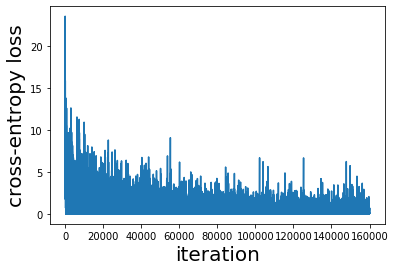

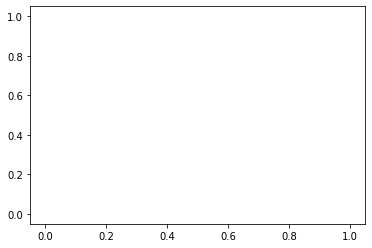

In [8]:
plt.figure()
plt.plot(range(len(history_trainingloss)), history_trainingloss)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("cross-entropy loss", fontsize=20)
plt.show()
plt.figure()
plt.plot(range(len(history_testloss)), history_testloss)
plt.show()

# Evaluation Phase

statcollector created.
 loading initial bigchunks, please wait ....
     bigchunk 0 from 5, please wait ...

     bigchunk 1 from 5, please wait ...

     bigchunk 2 from 5, please wait ...

     bigchunk 3 from 5, please wait ...

     bigchunk 4 from 5, please wait ...

The initial loading of bigchunks took 26.424628973007202 seconds.
 got 10 stats
self.num_calls_to_getflagfinished = 1

 numstats in [0 , 37],     num zeros = 44


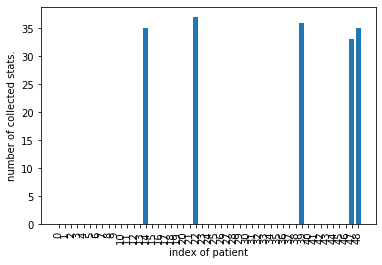

 got 20 stats
 got 30 stats
self.num_calls_to_getflagfinished = 2

 numstats in [0 , 101],     num zeros = 43


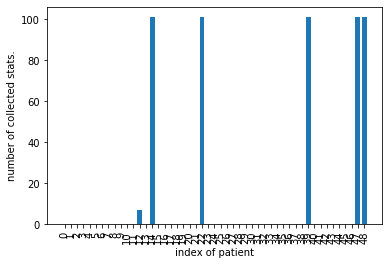

self.num_calls_to_getflagfinished = 3

 numstats in [0 , 101],     num zeros = 42


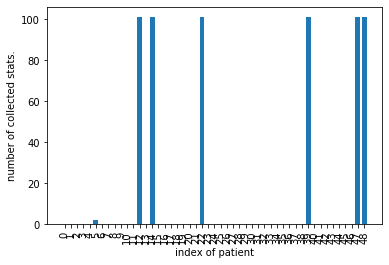

 got 40 stats
self.num_calls_to_getflagfinished = 4

 numstats in [0 , 101],     num zeros = 41


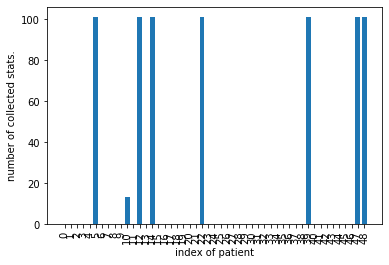

 got 50 stats
self.num_calls_to_getflagfinished = 5

 numstats in [0 , 101],     num zeros = 40


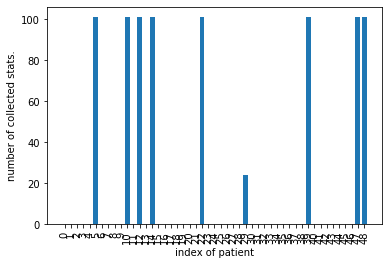

self.num_calls_to_getflagfinished = 6

 numstats in [0 , 101],     num zeros = 39


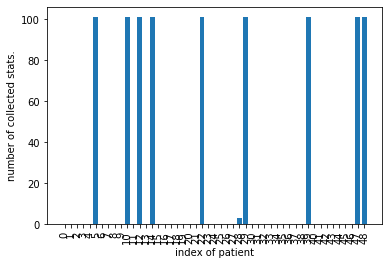

 got 60 stats
self.num_calls_to_getflagfinished = 7

 numstats in [0 , 101],     num zeros = 38


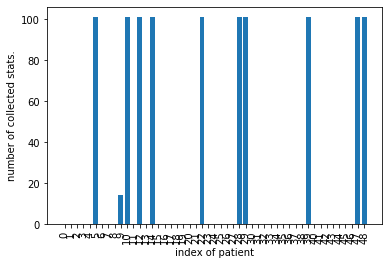

 got 70 stats
self.num_calls_to_getflagfinished = 8

 numstats in [0 , 101],     num zeros = 37


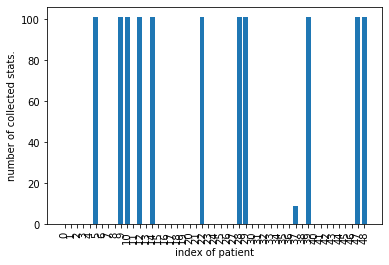

self.num_calls_to_getflagfinished = 9

 numstats in [0 , 101],     num zeros = 36


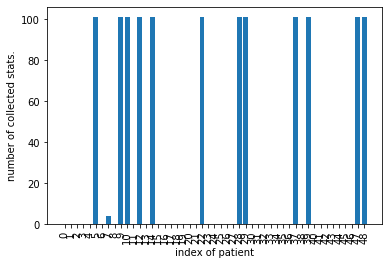

 got 80 stats
self.num_calls_to_getflagfinished = 10

 numstats in [0 , 101],     num zeros = 35


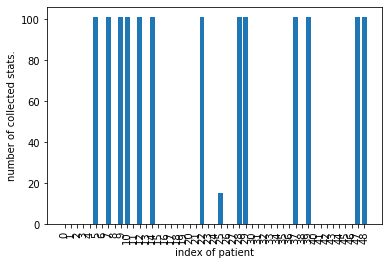

self.num_calls_to_getflagfinished = 11

 numstats in [0 , 101],     num zeros = 34


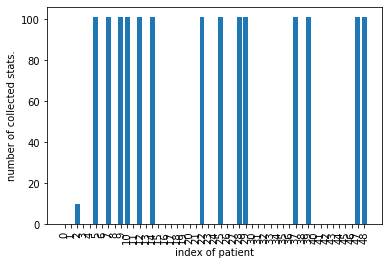

 got 90 stats
self.num_calls_to_getflagfinished = 12

 numstats in [0 , 101],     num zeros = 33


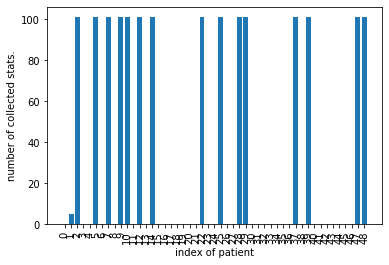

 got 100 stats
self.num_calls_to_getflagfinished = 13

 numstats in [0 , 101],     num zeros = 32


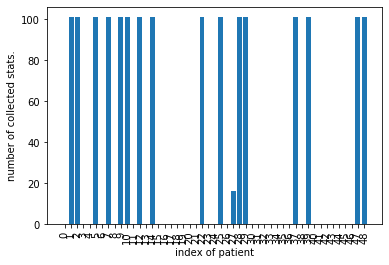

self.num_calls_to_getflagfinished = 14

 numstats in [0 , 101],     num zeros = 31


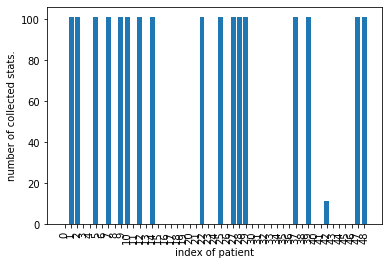

 got 110 stats
self.num_calls_to_getflagfinished = 15

 numstats in [0 , 101],     num zeros = 30


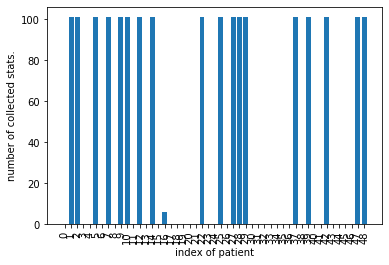

 got 120 stats
self.num_calls_to_getflagfinished = 16

 numstats in [0 , 101],     num zeros = 29


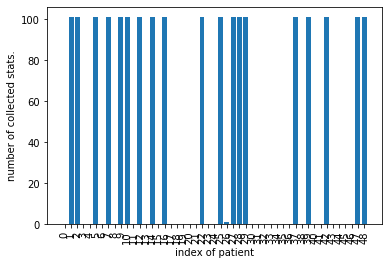

self.num_calls_to_getflagfinished = 17

 numstats in [0 , 101],     num zeros = 28


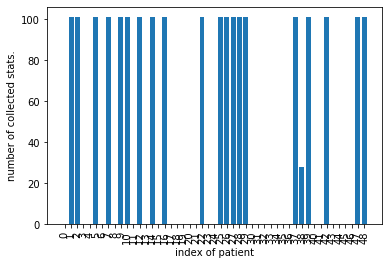

 got 130 stats
self.num_calls_to_getflagfinished = 18

 numstats in [0 , 101],     num zeros = 27


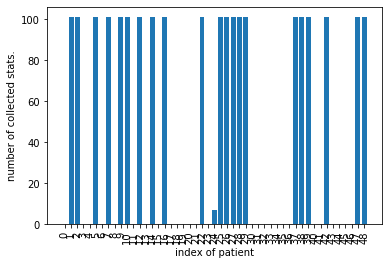

self.num_calls_to_getflagfinished = 19

 numstats in [0 , 101],     num zeros = 26


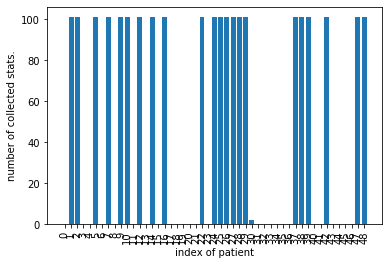

 got 140 stats
self.num_calls_to_getflagfinished = 20

 numstats in [0 , 101],     num zeros = 25


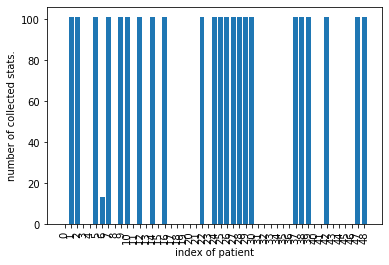

 got 150 stats
self.num_calls_to_getflagfinished = 21

 numstats in [0 , 101],     num zeros = 24


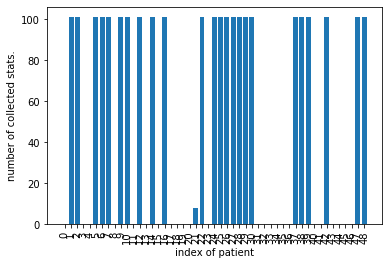

self.num_calls_to_getflagfinished = 22

 numstats in [0 , 101],     num zeros = 23


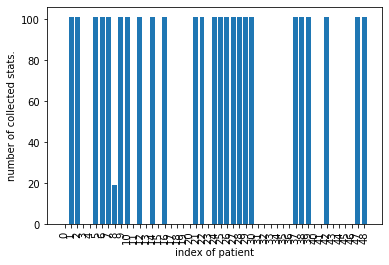

 got 160 stats
self.num_calls_to_getflagfinished = 23

 numstats in [0 , 101],     num zeros = 22


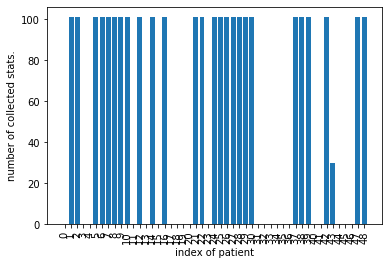

 got 170 stats
self.num_calls_to_getflagfinished = 24

 numstats in [0 , 101],     num zeros = 21


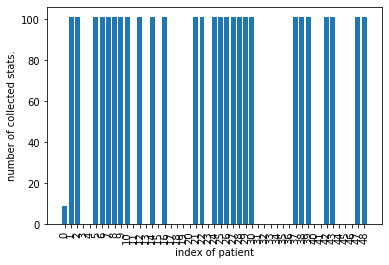

 got 180 stats
self.num_calls_to_getflagfinished = 25

 numstats in [0 , 101],     num zeros = 20


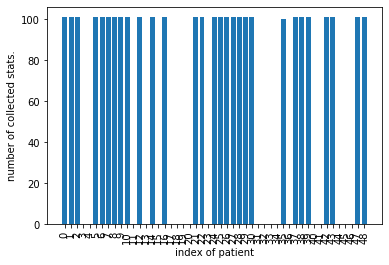

self.num_calls_to_getflagfinished = 26

 numstats in [0 , 101],     num zeros = 19


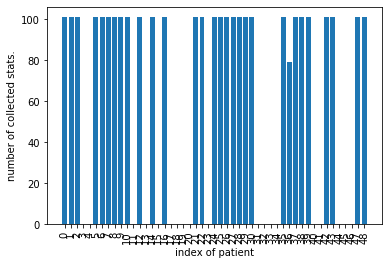

 got 190 stats
self.num_calls_to_getflagfinished = 27

 numstats in [0 , 101],     num zeros = 18


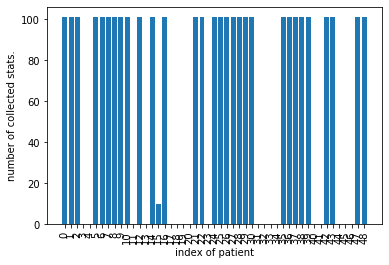

self.num_calls_to_getflagfinished = 28

 numstats in [0 , 101],     num zeros = 17


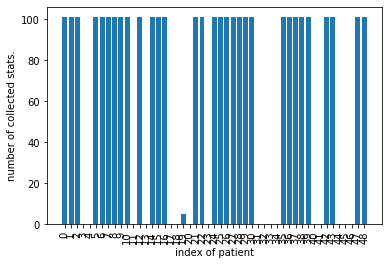

 got 200 stats
self.num_calls_to_getflagfinished = 29

 numstats in [0 , 101],     num zeros = 16


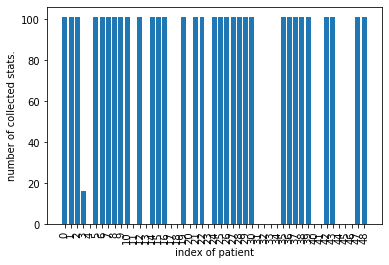

self.num_calls_to_getflagfinished = 30

 numstats in [0 , 101],     num zeros = 15


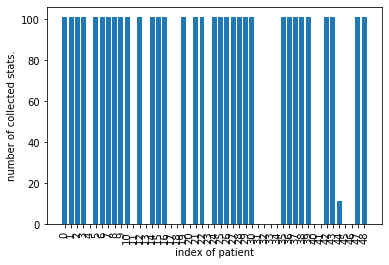

 got 210 stats
self.num_calls_to_getflagfinished = 31

 numstats in [0 , 101],     num zeros = 14


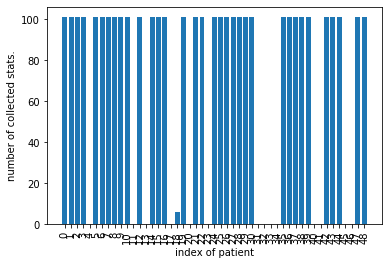

 got 220 stats
self.num_calls_to_getflagfinished = 32

 numstats in [0 , 101],     num zeros = 13


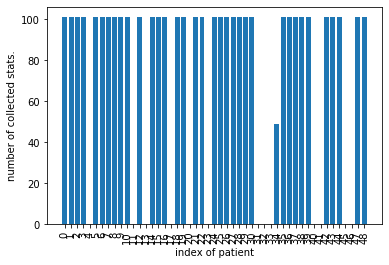

self.num_calls_to_getflagfinished = 33

 numstats in [0 , 101],     num zeros = 12


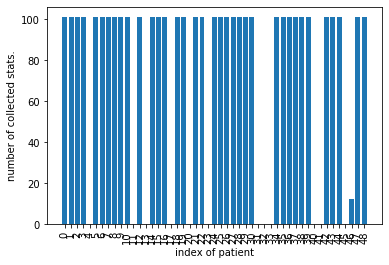

 got 230 stats
self.num_calls_to_getflagfinished = 34

 numstats in [0 , 101],     num zeros = 11


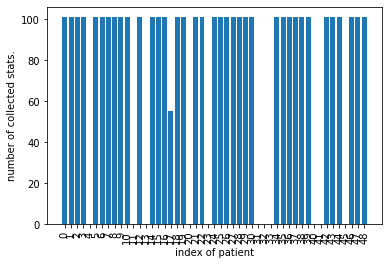

 got 240 stats
self.num_calls_to_getflagfinished = 35

 numstats in [0 , 101],     num zeros = 10


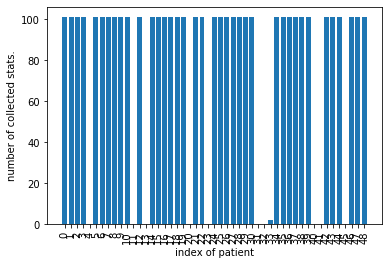

self.num_calls_to_getflagfinished = 36

 numstats in [0 , 101],     num zeros = 9


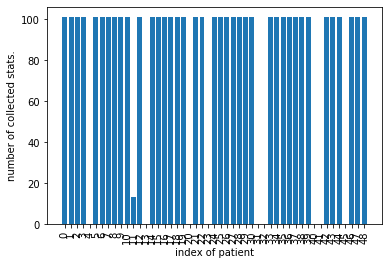

 got 250 stats
self.num_calls_to_getflagfinished = 37

 numstats in [0 , 101],     num zeros = 8


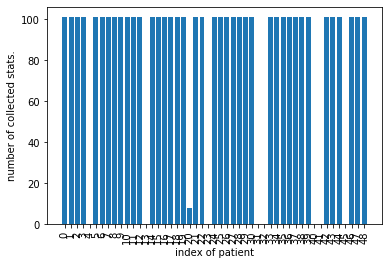

self.num_calls_to_getflagfinished = 38

 numstats in [0 , 101],     num zeros = 7


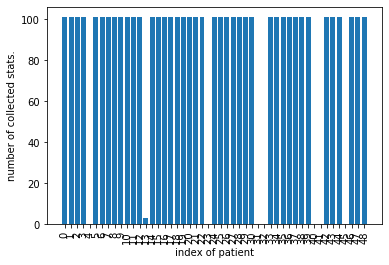

 got 260 stats
self.num_calls_to_getflagfinished = 39

 numstats in [0 , 101],     num zeros = 6


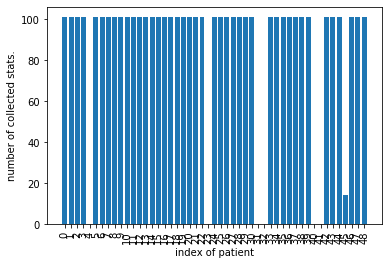

 got 270 stats
self.num_calls_to_getflagfinished = 40

 numstats in [0 , 101],     num zeros = 5


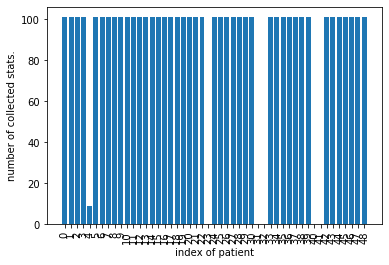

self.num_calls_to_getflagfinished = 41

 numstats in [0 , 101],     num zeros = 4


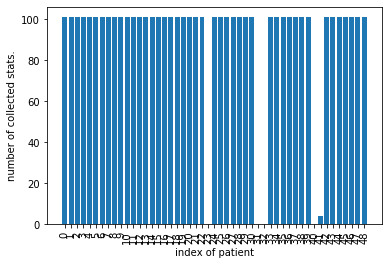

 got 280 stats
self.num_calls_to_getflagfinished = 42

 numstats in [0 , 101],     num zeros = 3


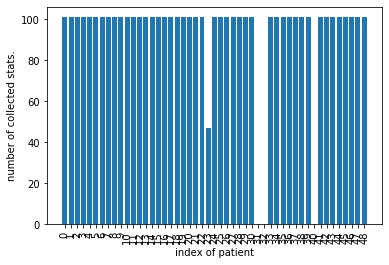

 got 290 stats
self.num_calls_to_getflagfinished = 43

 numstats in [0 , 101],     num zeros = 2


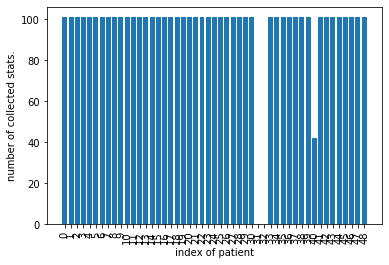

self.num_calls_to_getflagfinished = 44

 numstats in [0 , 101],     num zeros = 1


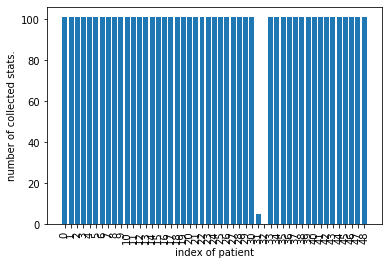

 got 300 stats
self.num_calls_to_getflagfinished = 45

 numstats in [16 , 101],     num zeros = 0


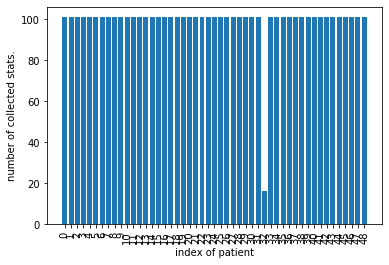

 got 310 stats
self.num_calls_to_getflagfinished = 46

 numstats in [101 , 112],     num zeros = 0


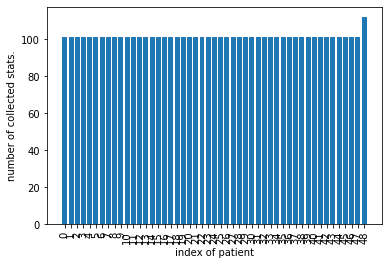

self.num_calls_to_getflagfinished = 47

 numstats in [101 , 202],     num zeros = 0


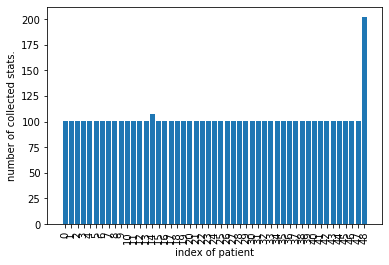

 got 320 stats
self.num_calls_to_getflagfinished = 48

 numstats in [101 , 202],     num zeros = 0


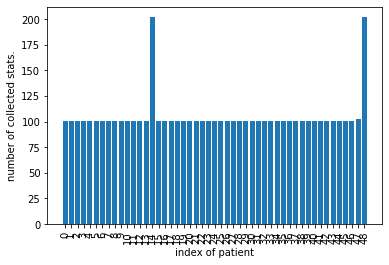

self.num_calls_to_getflagfinished = 49

 numstats in [101 , 202],     num zeros = 0


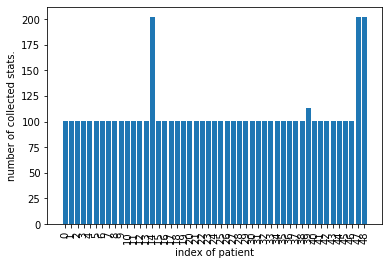

 got 330 stats
self.num_calls_to_getflagfinished = 50

 numstats in [101 , 202],     num zeros = 0


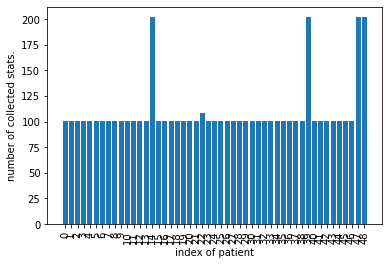

 got 340 stats
self.num_calls_to_getflagfinished = 51

 numstats in [101 , 202],     num zeros = 0


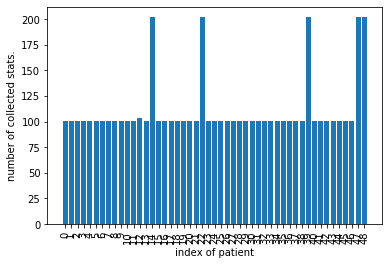

self.num_calls_to_getflagfinished = 52

 numstats in [101 , 202],     num zeros = 0


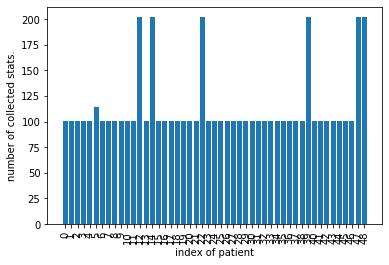

 got 350 stats
self.num_calls_to_getflagfinished = 53

 numstats in [101 , 202],     num zeros = 0


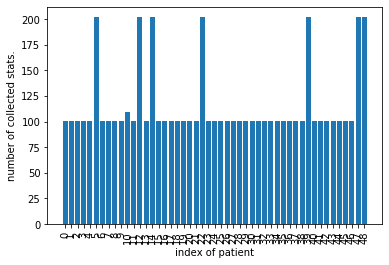

 got 360 stats
self.num_calls_to_getflagfinished = 54

 numstats in [101 , 202],     num zeros = 0


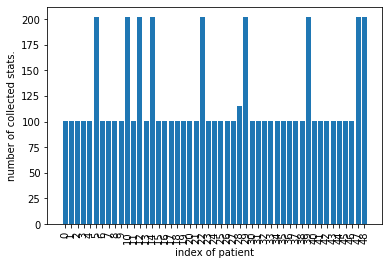

 got 370 stats
self.num_calls_to_getflagfinished = 55

 numstats in [101 , 202],     num zeros = 0


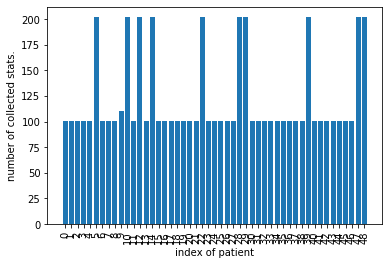

self.num_calls_to_getflagfinished = 56

 numstats in [101 , 202],     num zeros = 0


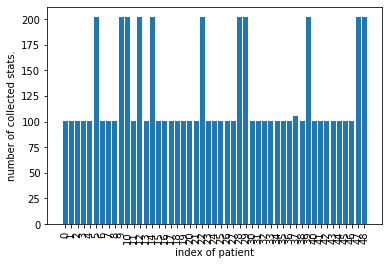

 got 380 stats
self.num_calls_to_getflagfinished = 57

 numstats in [101 , 202],     num zeros = 0


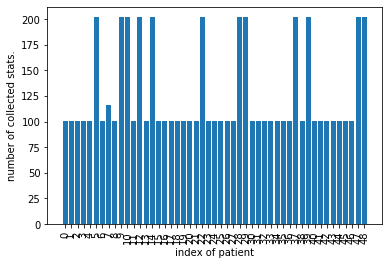

 got 390 stats
self.num_calls_to_getflagfinished = 58

 numstats in [101 , 202],     num zeros = 0


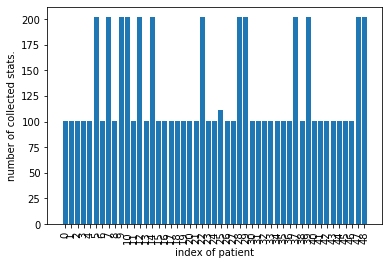

self.num_calls_to_getflagfinished = 59

 numstats in [101 , 202],     num zeros = 0


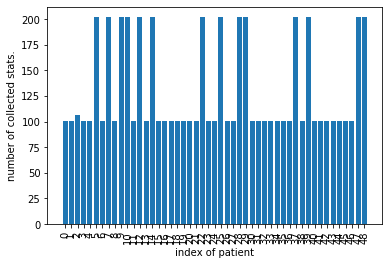

 got 400 stats
self.num_calls_to_getflagfinished = 60

 numstats in [101 , 202],     num zeros = 0


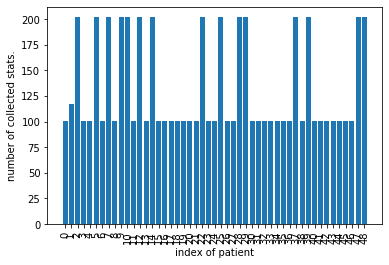

 got 410 stats
self.num_calls_to_getflagfinished = 61

 numstats in [101 , 202],     num zeros = 0


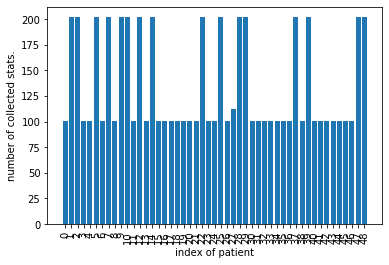

self.num_calls_to_getflagfinished = 62

 numstats in [101 , 202],     num zeros = 0


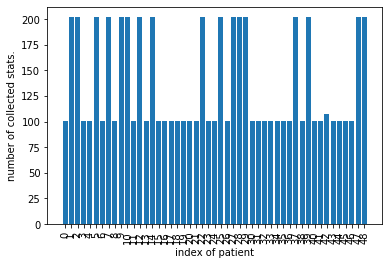

 got 420 stats
self.num_calls_to_getflagfinished = 63

 numstats in [101 , 202],     num zeros = 0


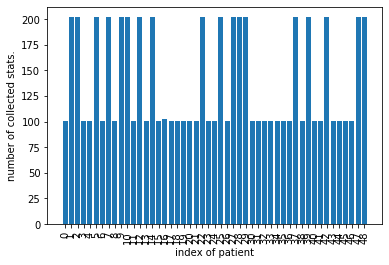

 got 430 stats
self.num_calls_to_getflagfinished = 64

 numstats in [101 , 202],     num zeros = 0


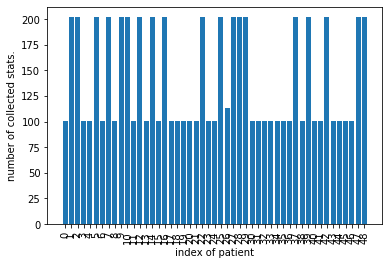

 got 440 stats
self.num_calls_to_getflagfinished = 65

 numstats in [101 , 202],     num zeros = 0


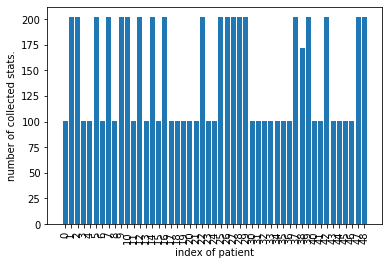

self.num_calls_to_getflagfinished = 66

 numstats in [101 , 202],     num zeros = 0


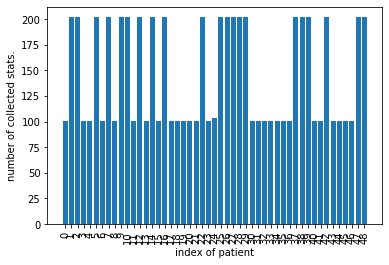

self.num_calls_to_getflagfinished = 67

 numstats in [101 , 202],     num zeros = 0


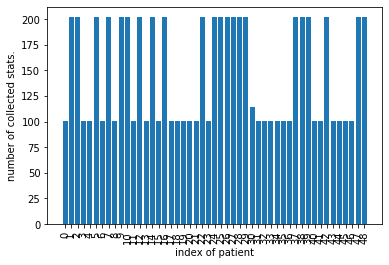

 got 450 stats
self.num_calls_to_getflagfinished = 68

 numstats in [101 , 202],     num zeros = 0


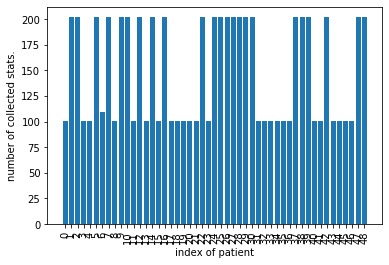

 got 460 stats
self.num_calls_to_getflagfinished = 69

 numstats in [101 , 202],     num zeros = 0


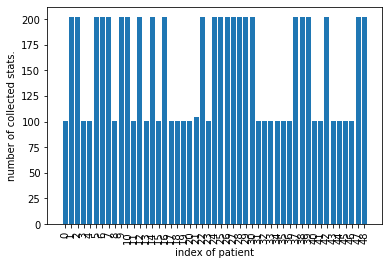

self.num_calls_to_getflagfinished = 70

 numstats in [101 , 202],     num zeros = 0


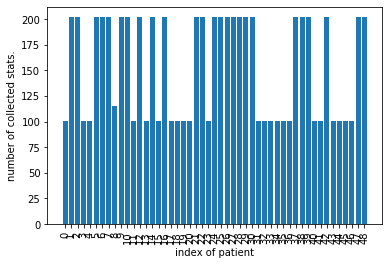

 got 470 stats
self.num_calls_to_getflagfinished = 71

 numstats in [101 , 202],     num zeros = 0


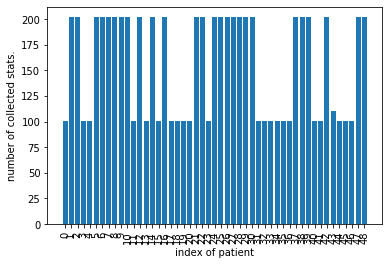

 got 480 stats
self.num_calls_to_getflagfinished = 72

 numstats in [101 , 202],     num zeros = 0


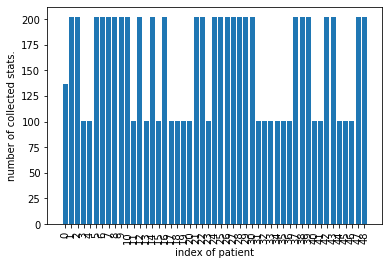

 got 490 stats
self.num_calls_to_getflagfinished = 73

 numstats in [101 , 202],     num zeros = 0


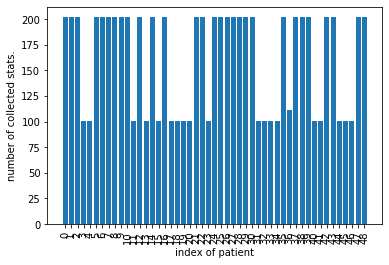

self.num_calls_to_getflagfinished = 74

 numstats in [101 , 202],     num zeros = 0


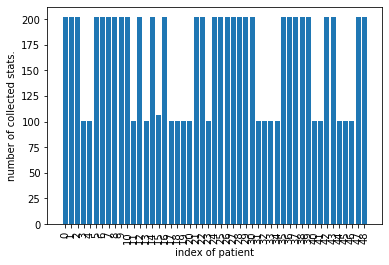

 got 500 stats
self.num_calls_to_getflagfinished = 75

 numstats in [101 , 202],     num zeros = 0


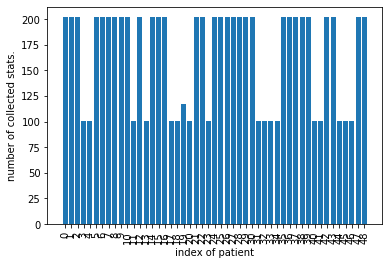

 got 510 stats
self.num_calls_to_getflagfinished = 76

 numstats in [101 , 202],     num zeros = 0


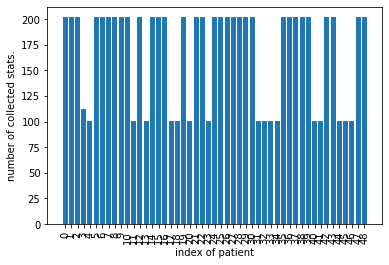

self.num_calls_to_getflagfinished = 77

 numstats in [101 , 202],     num zeros = 0


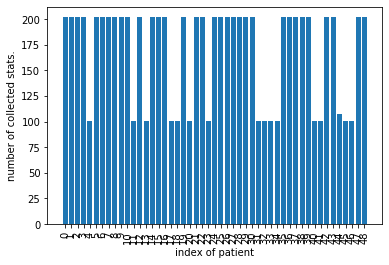

 got 520 stats
self.num_calls_to_getflagfinished = 78

 numstats in [101 , 202],     num zeros = 0


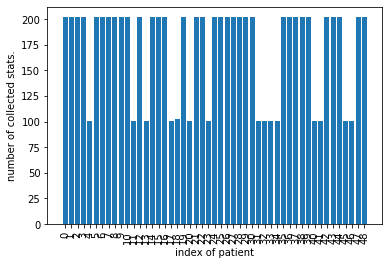

 got 530 stats
self.num_calls_to_getflagfinished = 79

 numstats in [101 , 202],     num zeros = 0


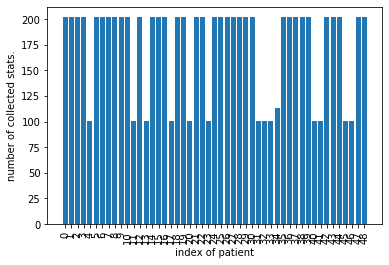

self.num_calls_to_getflagfinished = 80

 numstats in [101 , 202],     num zeros = 0


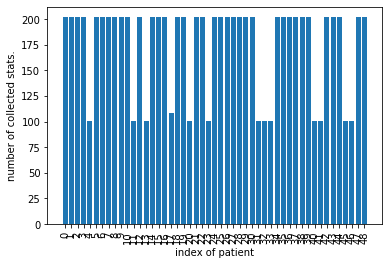

 got 540 stats
 got 550 stats
self.num_calls_to_getflagfinished = 81

 numstats in [101 , 202],     num zeros = 0


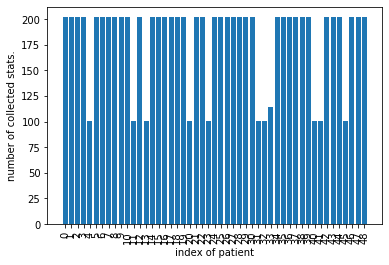

self.num_calls_to_getflagfinished = 82

 numstats in [101 , 202],     num zeros = 0


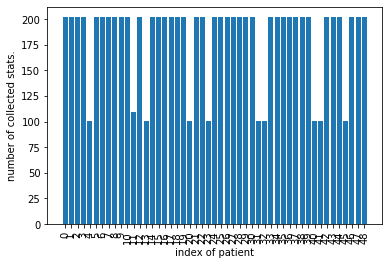

 got 560 stats
self.num_calls_to_getflagfinished = 83

 numstats in [101 , 202],     num zeros = 0


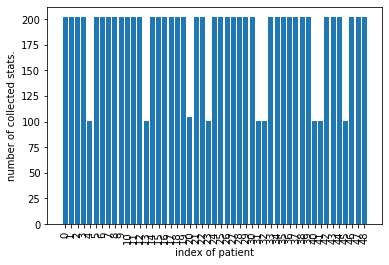

self.num_calls_to_getflagfinished = 84

 numstats in [101 , 202],     num zeros = 0


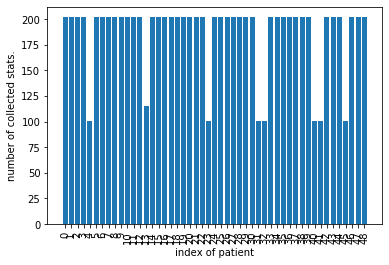

 got 570 stats
self.num_calls_to_getflagfinished = 85

 numstats in [101 , 202],     num zeros = 0


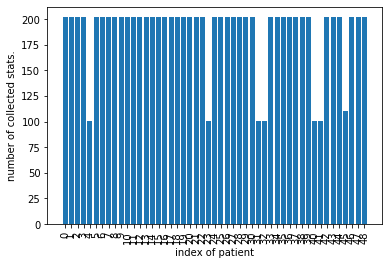

 got 580 stats
self.num_calls_to_getflagfinished = 86

 numstats in [101 , 202],     num zeros = 0


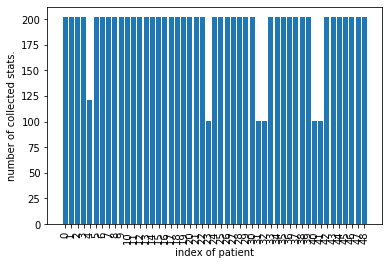

self.num_calls_to_getflagfinished = 87

 numstats in [101 , 202],     num zeros = 0


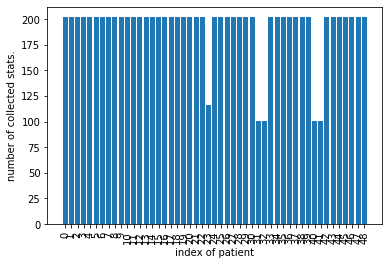

 got 590 stats
self.num_calls_to_getflagfinished = 88

 numstats in [101 , 202],     num zeros = 0


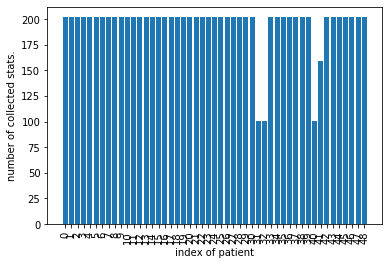

 got 600 stats
self.num_calls_to_getflagfinished = 89

 numstats in [101 , 202],     num zeros = 0


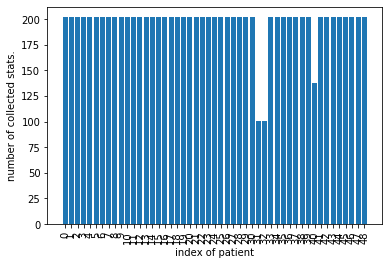

self.num_calls_to_getflagfinished = 90

 numstats in [101 , 202],     num zeros = 0


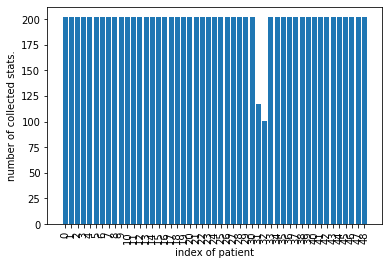

 got 610 stats
self.num_calls_to_getflagfinished = 91

 numstats in [112 , 202],     num zeros = 0


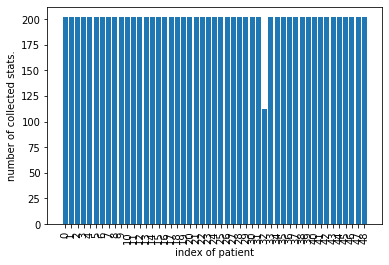

self.num_calls_to_getflagfinished = 92

 numstats in [202 , 208],     num zeros = 0


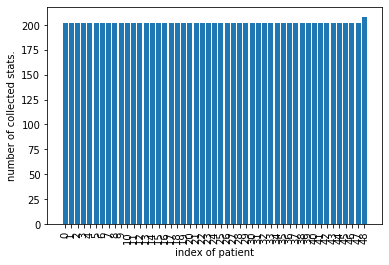

 got 620 stats
self.num_calls_to_getflagfinished = 93

 numstats in [202 , 303],     num zeros = 0


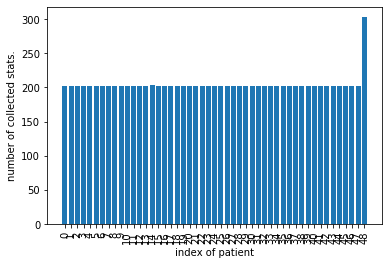

 got 630 stats
self.num_calls_to_getflagfinished = 94

 numstats in [202 , 303],     num zeros = 0


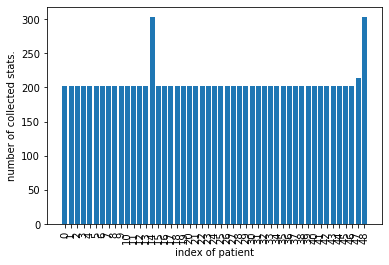

self.num_calls_to_getflagfinished = 95

 numstats in [202 , 303],     num zeros = 0


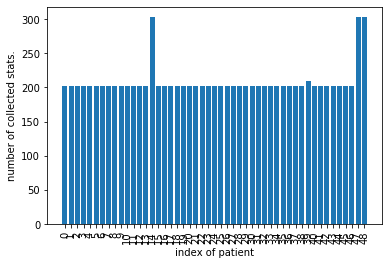

 got 640 stats
self.num_calls_to_getflagfinished = 96

 numstats in [202 , 303],     num zeros = 0


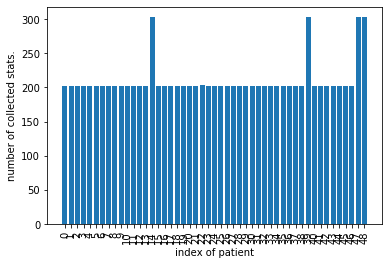

 got 650 stats
self.num_calls_to_getflagfinished = 97

 numstats in [202 , 303],     num zeros = 0


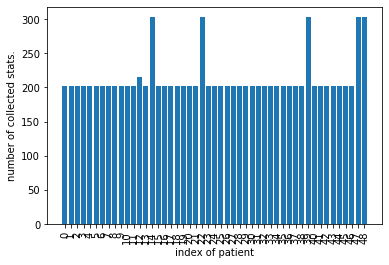

self.num_calls_to_getflagfinished = 98

 numstats in [202 , 303],     num zeros = 0


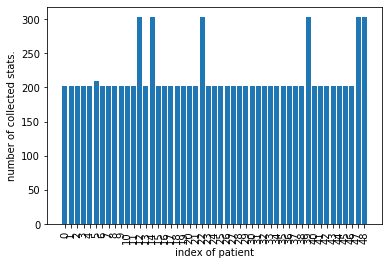

 got 660 stats
self.num_calls_to_getflagfinished = 99

 numstats in [202 , 303],     num zeros = 0


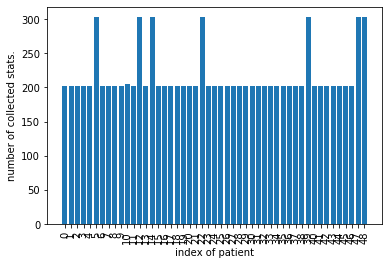

 got 670 stats
self.num_calls_to_getflagfinished = 100

 numstats in [202 , 303],     num zeros = 0


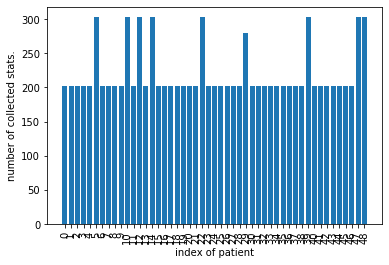

self.num_calls_to_getflagfinished = 101

 numstats in [202 , 303],     num zeros = 0


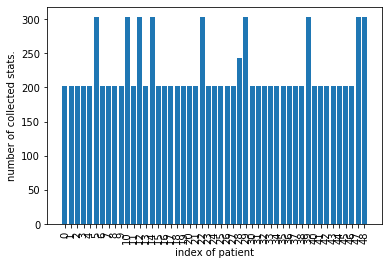

 got 680 stats
self.num_calls_to_getflagfinished = 102

 numstats in [202 , 303],     num zeros = 0


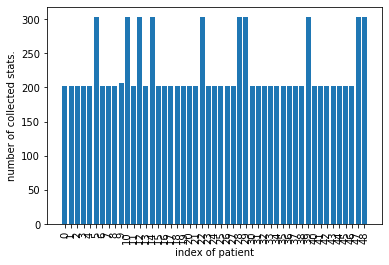

self.num_calls_to_getflagfinished = 103

 numstats in [202 , 303],     num zeros = 0


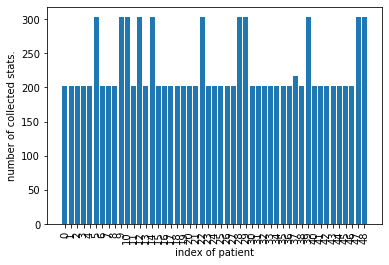

 got 690 stats
self.num_calls_to_getflagfinished = 104

 numstats in [202 , 303],     num zeros = 0


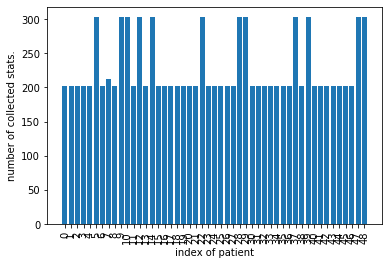

 got 700 stats
self.num_calls_to_getflagfinished = 105

 numstats in [202 , 303],     num zeros = 0


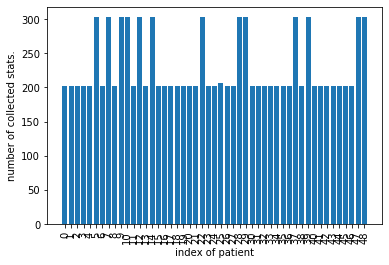

self.num_calls_to_getflagfinished = 106

 numstats in [202 , 303],     num zeros = 0


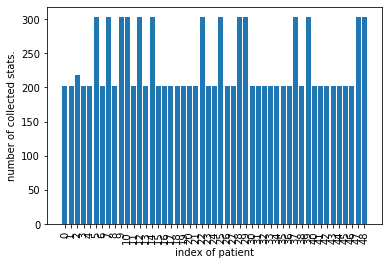

 got 710 stats
self.num_calls_to_getflagfinished = 107

 numstats in [202 , 303],     num zeros = 0


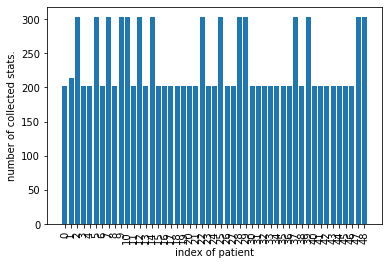

 got 720 stats
self.num_calls_to_getflagfinished = 108

 numstats in [202 , 303],     num zeros = 0


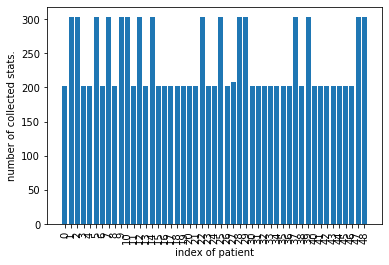

self.num_calls_to_getflagfinished = 109

 numstats in [202 , 303],     num zeros = 0


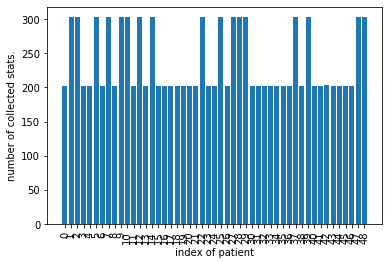

 got 730 stats
self.num_calls_to_getflagfinished = 110

 numstats in [202 , 303],     num zeros = 0


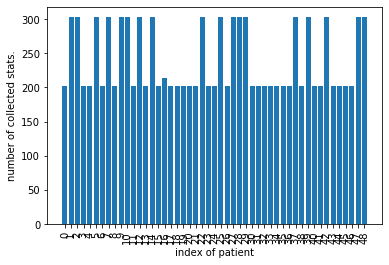

self.num_calls_to_getflagfinished = 111

 numstats in [202 , 303],     num zeros = 0


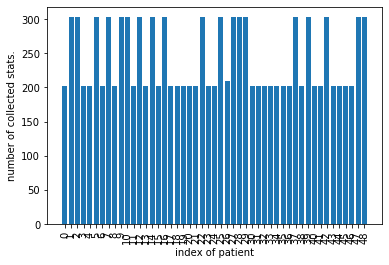

 got 740 stats
self.num_calls_to_getflagfinished = 112

 numstats in [202 , 303],     num zeros = 0


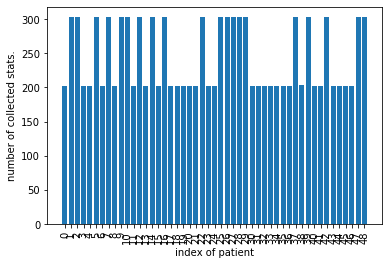

 got 750 stats
self.num_calls_to_getflagfinished = 113

 numstats in [202 , 303],     num zeros = 0


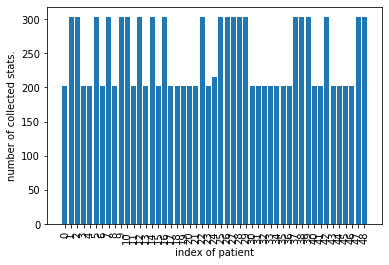

self.num_calls_to_getflagfinished = 114

 numstats in [202 , 303],     num zeros = 0


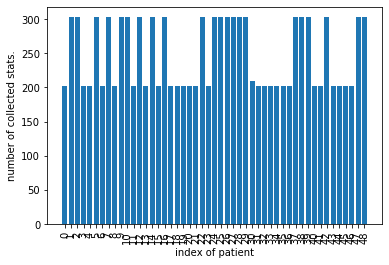

 got 760 stats
self.num_calls_to_getflagfinished = 115

 numstats in [202 , 303],     num zeros = 0


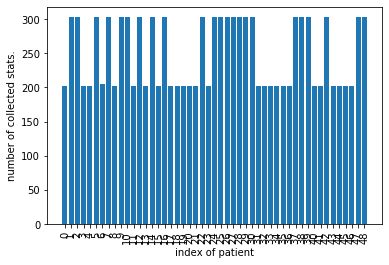

 got 770 stats
self.num_calls_to_getflagfinished = 116

 numstats in [202 , 303],     num zeros = 0


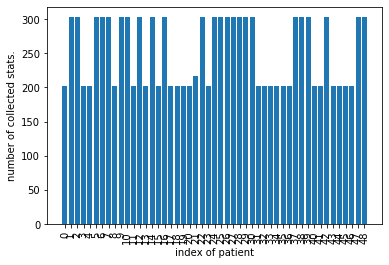

self.num_calls_to_getflagfinished = 117

 numstats in [202 , 303],     num zeros = 0


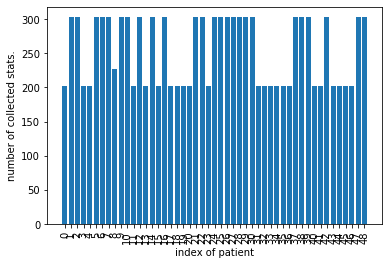

 got 780 stats
self.num_calls_to_getflagfinished = 118

 numstats in [202 , 303],     num zeros = 0


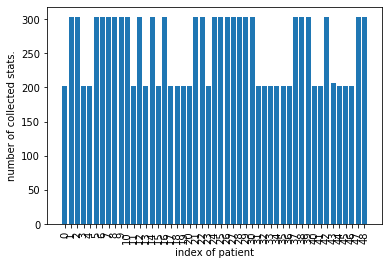

 got 790 stats
self.num_calls_to_getflagfinished = 119

 numstats in [202 , 303],     num zeros = 0


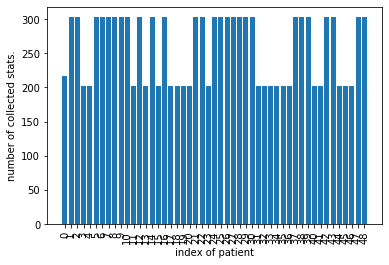

 got 800 stats
self.num_calls_to_getflagfinished = 120

 numstats in [202 , 303],     num zeros = 0


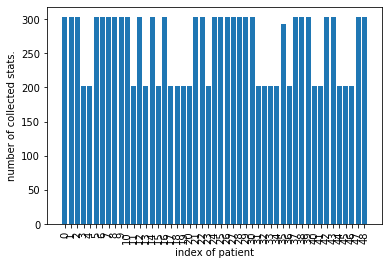

self.num_calls_to_getflagfinished = 121

 numstats in [202 , 303],     num zeros = 0


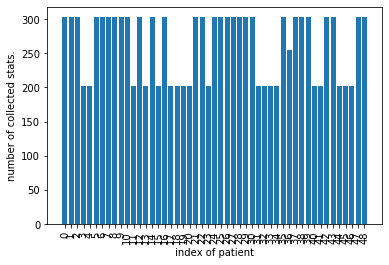

self.num_calls_to_getflagfinished = 122

 numstats in [202 , 303],     num zeros = 0


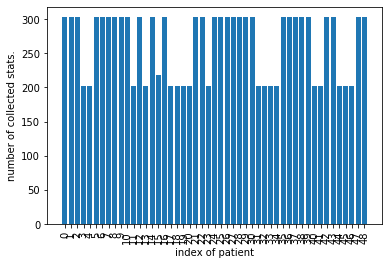

 got 810 stats
self.num_calls_to_getflagfinished = 123

 numstats in [202 , 303],     num zeros = 0


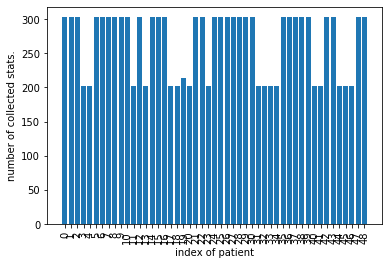

 got 820 stats
self.num_calls_to_getflagfinished = 124

 numstats in [202 , 303],     num zeros = 0


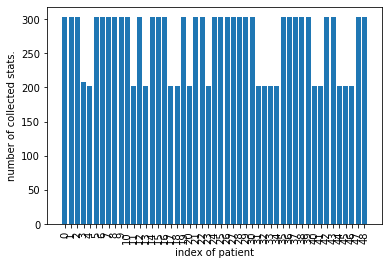

self.num_calls_to_getflagfinished = 125

 numstats in [202 , 303],     num zeros = 0


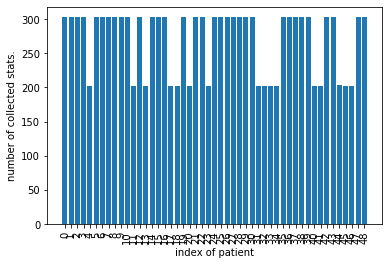

 got 830 stats
self.num_calls_to_getflagfinished = 126

 numstats in [202 , 303],     num zeros = 0


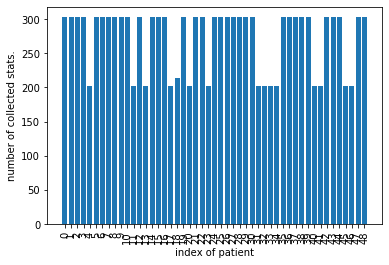

 got 840 stats
self.num_calls_to_getflagfinished = 127

 numstats in [202 , 303],     num zeros = 0


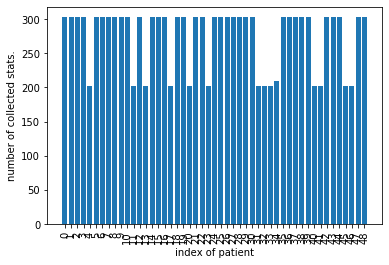

self.num_calls_to_getflagfinished = 128

 numstats in [202 , 303],     num zeros = 0


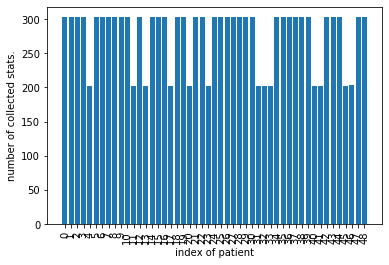

 got 850 stats
self.num_calls_to_getflagfinished = 129

 numstats in [202 , 303],     num zeros = 0


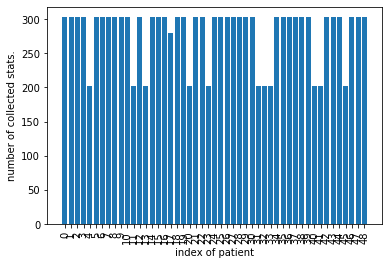

self.num_calls_to_getflagfinished = 130

 numstats in [202 , 303],     num zeros = 0


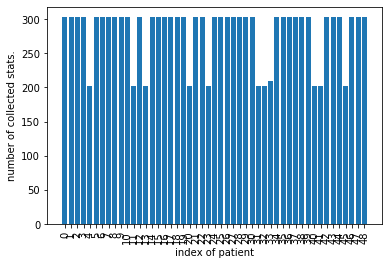

 got 860 stats
self.num_calls_to_getflagfinished = 131

 numstats in [202 , 303],     num zeros = 0


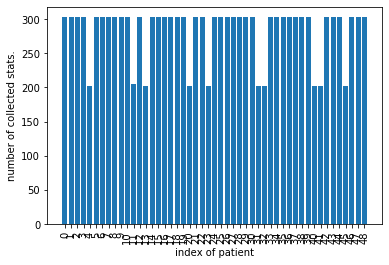

 got 870 stats
self.num_calls_to_getflagfinished = 132

 numstats in [202 , 303],     num zeros = 0


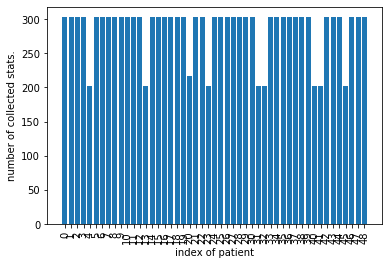

self.num_calls_to_getflagfinished = 133

 numstats in [202 , 303],     num zeros = 0


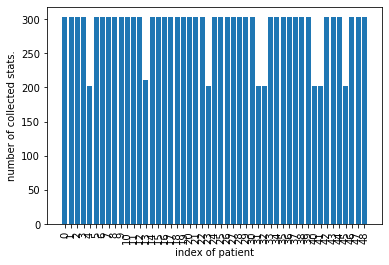

 got 880 stats
self.num_calls_to_getflagfinished = 134

 numstats in [202 , 303],     num zeros = 0


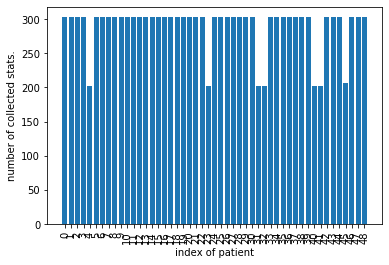

 got 890 stats
self.num_calls_to_getflagfinished = 135

 numstats in [202 , 303],     num zeros = 0


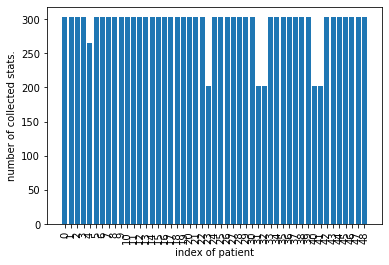

self.num_calls_to_getflagfinished = 136

 numstats in [202 , 303],     num zeros = 0


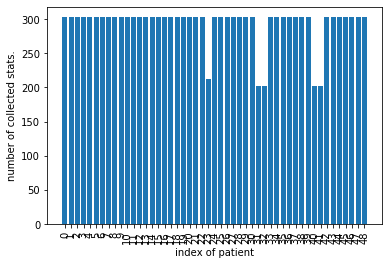

 got 900 stats
self.num_calls_to_getflagfinished = 137

 numstats in [202 , 303],     num zeros = 0


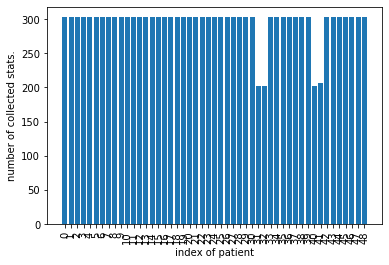

 got 910 stats
self.num_calls_to_getflagfinished = 138

 numstats in [202 , 303],     num zeros = 0


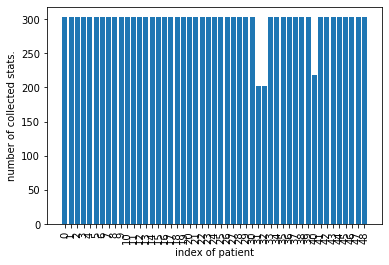

self.num_calls_to_getflagfinished = 139

 numstats in [202 , 303],     num zeros = 0


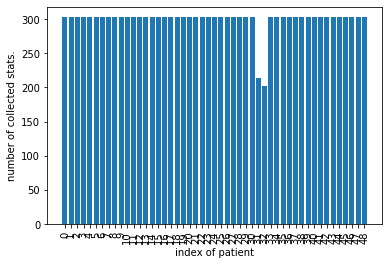

 got 920 stats
self.num_calls_to_getflagfinished = 140

 numstats in [208 , 303],     num zeros = 0


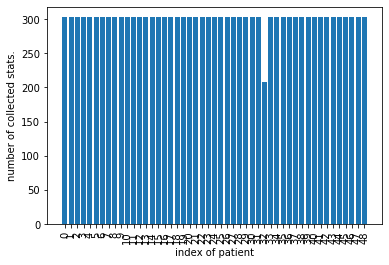

self.num_calls_to_getflagfinished = 141

 numstats in [303 , 304],     num zeros = 0


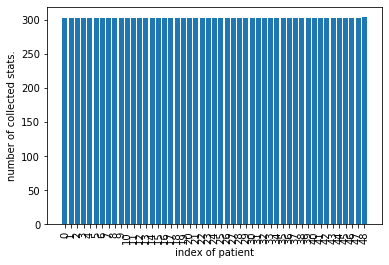

 got 930 stats
self.num_calls_to_getflagfinished = 142

 numstats in [303 , 404],     num zeros = 0


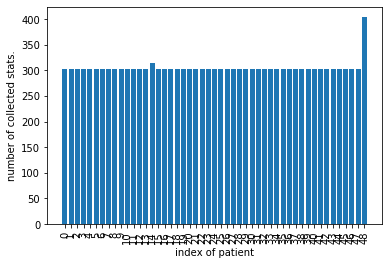

 got 940 stats
self.num_calls_to_getflagfinished = 143

 numstats in [303 , 404],     num zeros = 0


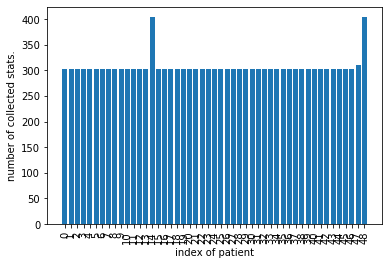

self.num_calls_to_getflagfinished = 144

 numstats in [303 , 404],     num zeros = 0


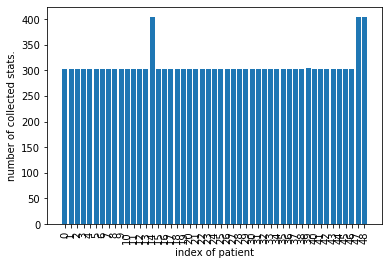

 got 950 stats
self.num_calls_to_getflagfinished = 145

 numstats in [303 , 404],     num zeros = 0


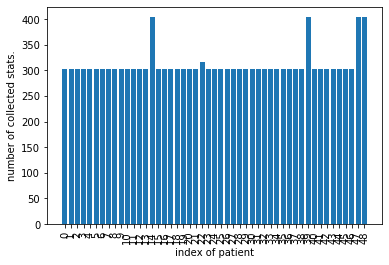

 got 960 stats
self.num_calls_to_getflagfinished = 146

 numstats in [303 , 404],     num zeros = 0


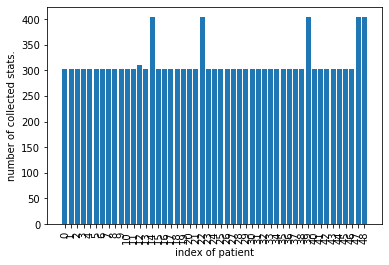

self.num_calls_to_getflagfinished = 147

 numstats in [303 , 404],     num zeros = 0


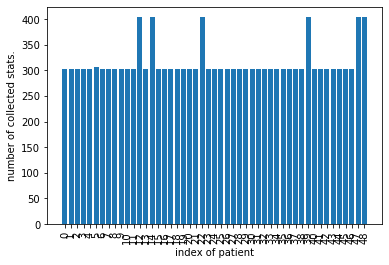

 got 970 stats
self.num_calls_to_getflagfinished = 148

 numstats in [303 , 404],     num zeros = 0


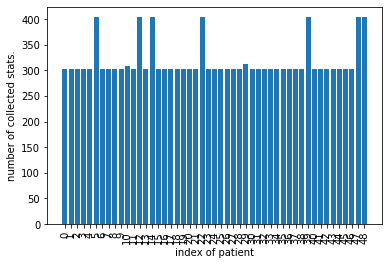

 got 980 stats
self.num_calls_to_getflagfinished = 149

 numstats in [303 , 404],     num zeros = 0


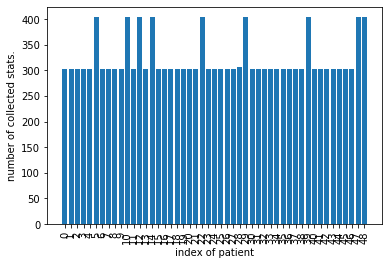

 got 990 stats
self.num_calls_to_getflagfinished = 150

 numstats in [303 , 404],     num zeros = 0


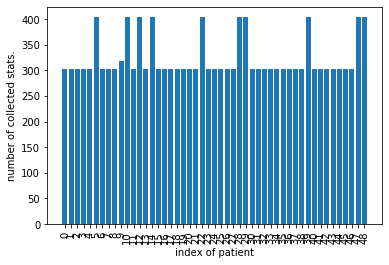

self.num_calls_to_getflagfinished = 151

 numstats in [303 , 404],     num zeros = 0


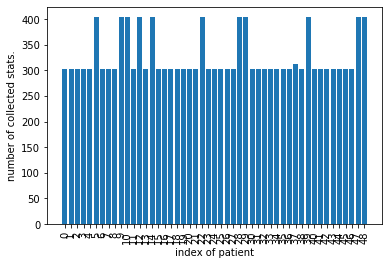

 got 1000 stats
self.num_calls_to_getflagfinished = 152

 numstats in [303 , 404],     num zeros = 0


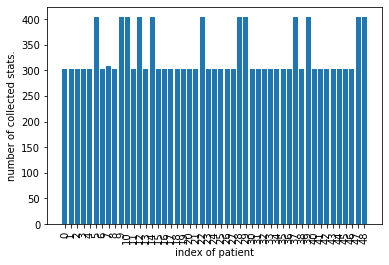

 got 1010 stats
self.num_calls_to_getflagfinished = 153

 numstats in [303 , 404],     num zeros = 0


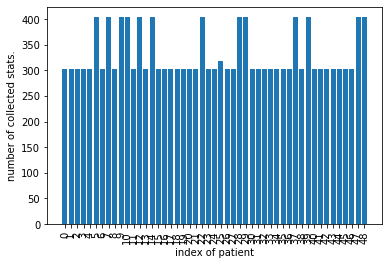

self.num_calls_to_getflagfinished = 154

 numstats in [303 , 404],     num zeros = 0


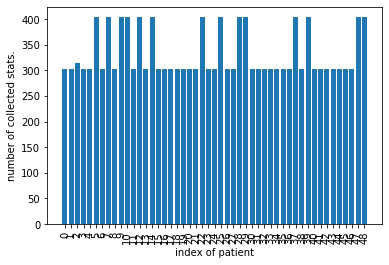

 got 1020 stats
self.num_calls_to_getflagfinished = 155

 numstats in [303 , 404],     num zeros = 0


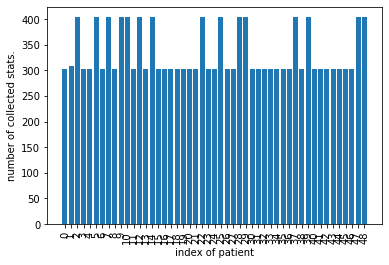

self.num_calls_to_getflagfinished = 156

 numstats in [303 , 404],     num zeros = 0


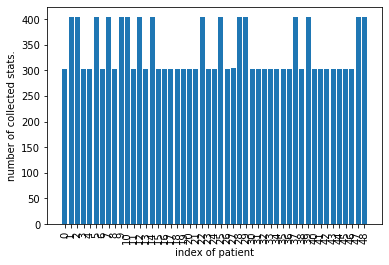

 got 1030 stats
self.num_calls_to_getflagfinished = 157

 numstats in [303 , 404],     num zeros = 0


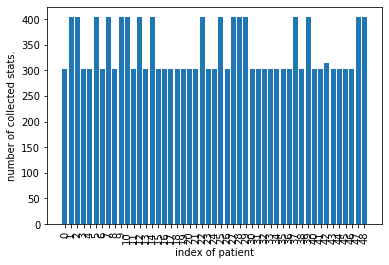

 got 1040 stats
self.num_calls_to_getflagfinished = 158

 numstats in [303 , 404],     num zeros = 0


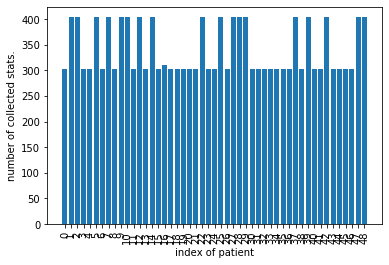

self.num_calls_to_getflagfinished = 159

 numstats in [303 , 404],     num zeros = 0


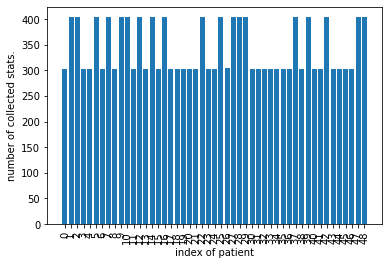

 got 1050 stats
self.num_calls_to_getflagfinished = 160

 numstats in [303 , 404],     num zeros = 0


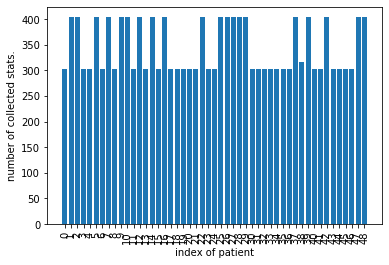

 got 1060 stats
self.num_calls_to_getflagfinished = 161

 numstats in [303 , 404],     num zeros = 0


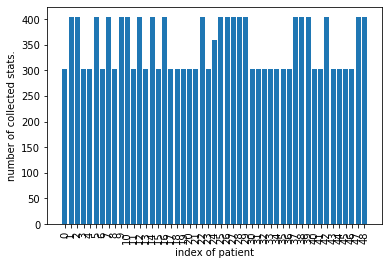

self.num_calls_to_getflagfinished = 162

 numstats in [303 , 404],     num zeros = 0


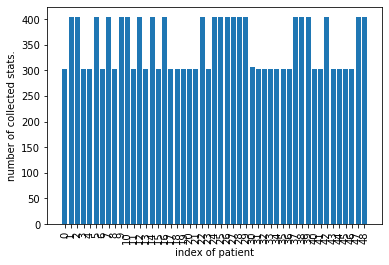

 got 1070 stats
self.num_calls_to_getflagfinished = 163

 numstats in [303 , 404],     num zeros = 0


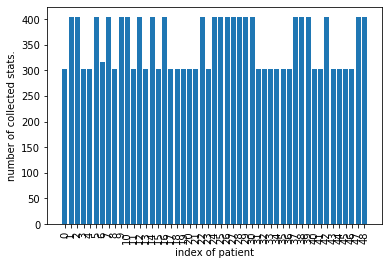

 got 1080 stats
self.num_calls_to_getflagfinished = 164

 numstats in [303 , 404],     num zeros = 0


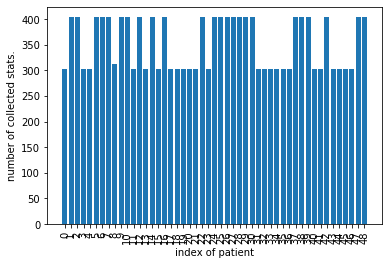

 got 1090 stats
self.num_calls_to_getflagfinished = 165

 numstats in [303 , 404],     num zeros = 0


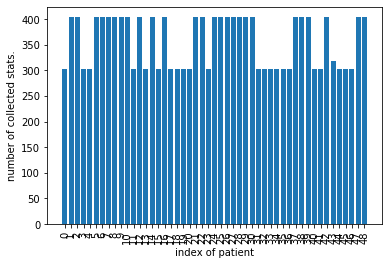

 got 1100 stats
self.num_calls_to_getflagfinished = 166

 numstats in [303 , 404],     num zeros = 0


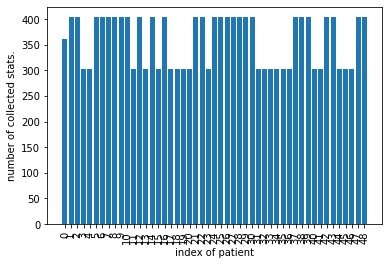

self.num_calls_to_getflagfinished = 167

 numstats in [303 , 404],     num zeros = 0


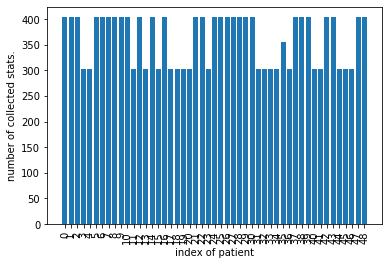

 got 1110 stats
self.num_calls_to_getflagfinished = 168

 numstats in [303 , 404],     num zeros = 0


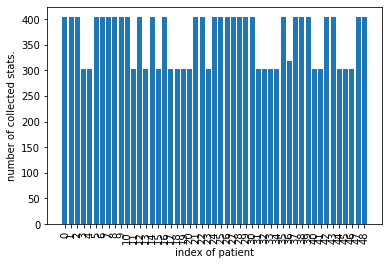

self.num_calls_to_getflagfinished = 169

 numstats in [303 , 404],     num zeros = 0


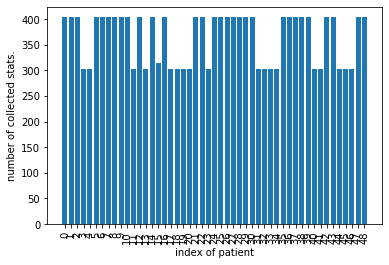

 got 1120 stats
self.num_calls_to_getflagfinished = 170

 numstats in [303 , 404],     num zeros = 0


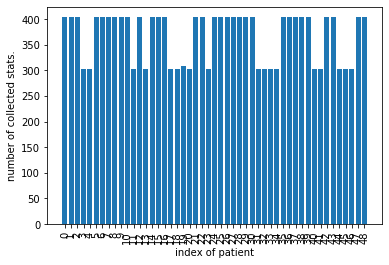

 got 1130 stats
self.num_calls_to_getflagfinished = 171

 numstats in [303 , 404],     num zeros = 0


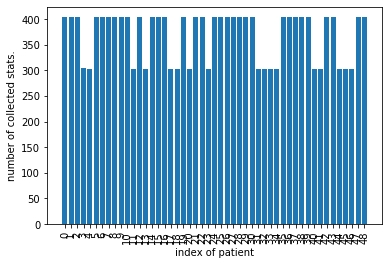

self.num_calls_to_getflagfinished = 172

 numstats in [303 , 404],     num zeros = 0


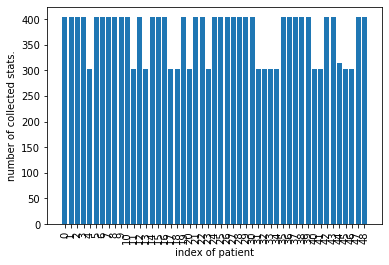

 got 1140 stats
self.num_calls_to_getflagfinished = 173

 numstats in [303 , 404],     num zeros = 0


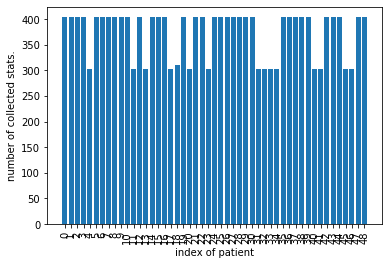

self.num_calls_to_getflagfinished = 174

 numstats in [303 , 404],     num zeros = 0


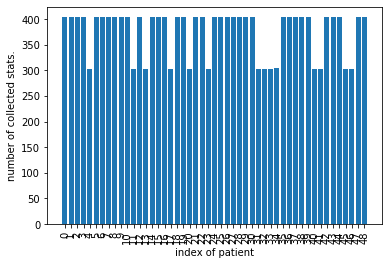

 got 1150 stats
self.num_calls_to_getflagfinished = 175

 numstats in [303 , 404],     num zeros = 0


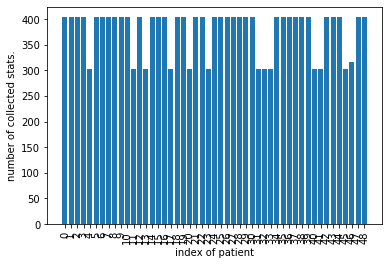

 got 1160 stats
self.num_calls_to_getflagfinished = 176

 numstats in [303 , 404],     num zeros = 0


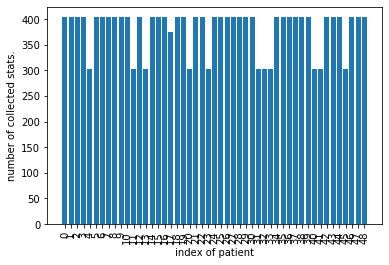

self.num_calls_to_getflagfinished = 177

 numstats in [303 , 404],     num zeros = 0


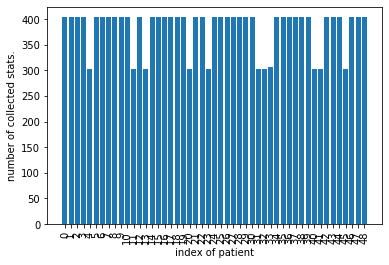

 got 1170 stats
self.num_calls_to_getflagfinished = 178

 numstats in [303 , 404],     num zeros = 0


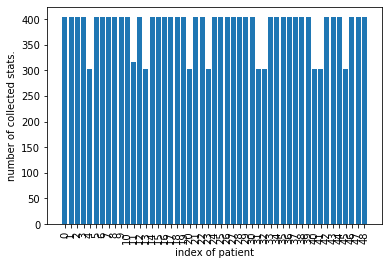

 got 1180 stats
self.num_calls_to_getflagfinished = 179

 numstats in [303 , 404],     num zeros = 0


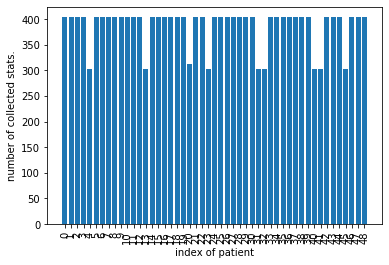

self.num_calls_to_getflagfinished = 180

 numstats in [303 , 404],     num zeros = 0


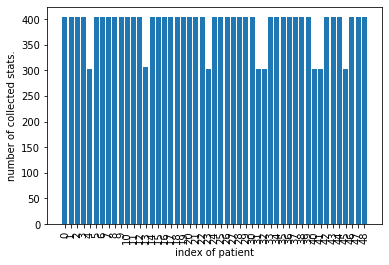

 got 1190 stats
self.num_calls_to_getflagfinished = 181

 numstats in [303 , 404],     num zeros = 0


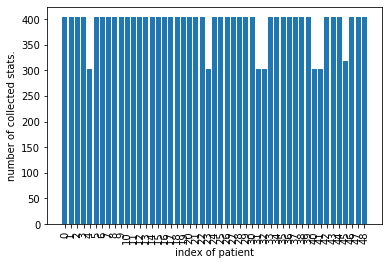

 got 1200 stats
self.num_calls_to_getflagfinished = 182

 numstats in [303 , 404],     num zeros = 0


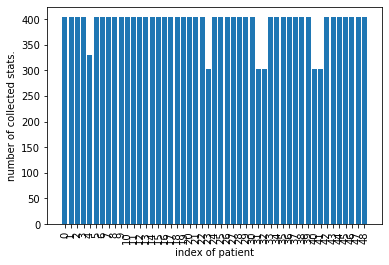

self.num_calls_to_getflagfinished = 183

 numstats in [303 , 404],     num zeros = 0


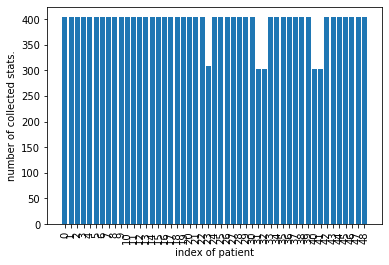

 got 1210 stats
self.num_calls_to_getflagfinished = 184

 numstats in [303 , 404],     num zeros = 0


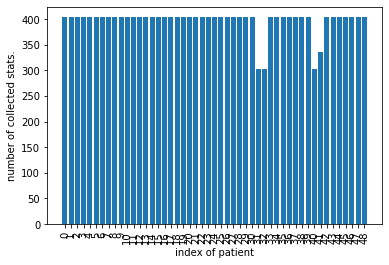

self.num_calls_to_getflagfinished = 185

 numstats in [303 , 404],     num zeros = 0


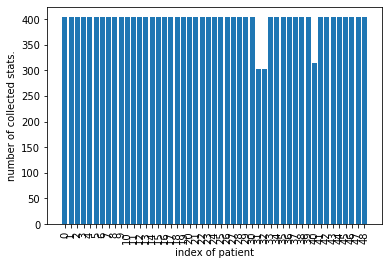

 got 1220 stats
self.num_calls_to_getflagfinished = 186

 numstats in [303 , 404],     num zeros = 0


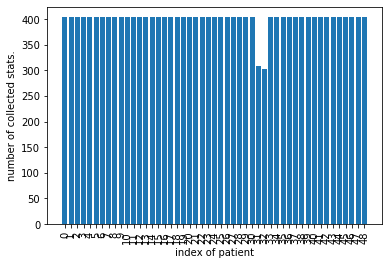

 got 1230 stats
self.num_calls_to_getflagfinished = 187

 numstats in [304 , 404],     num zeros = 0


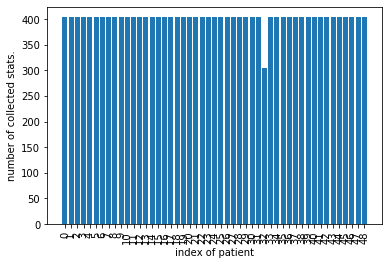

self.num_calls_to_getflagfinished = 188

 numstats in [404 , 416],     num zeros = 0


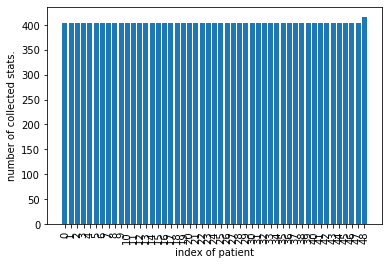

 got 1240 stats
self.num_calls_to_getflagfinished = 189

 numstats in [404 , 500],     num zeros = 0


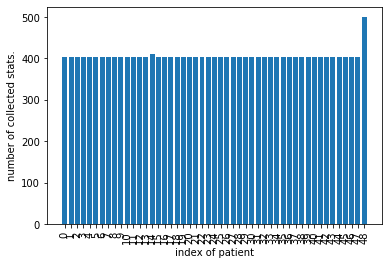

 got 1250 stats
self.num_calls_to_getflagfinished = 190

 numstats in [404 , 500],     num zeros = 0


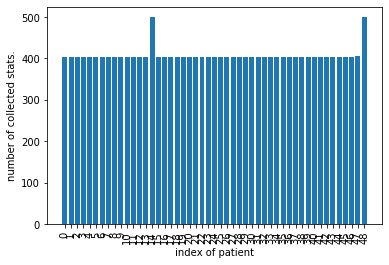

self.num_calls_to_getflagfinished = 191

 numstats in [404 , 500],     num zeros = 0


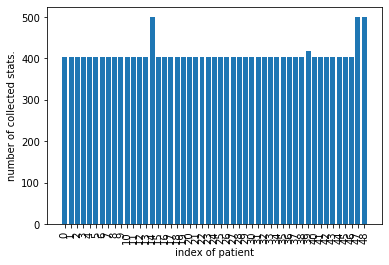

 got 1260 stats
self.num_calls_to_getflagfinished = 192

 numstats in [404 , 500],     num zeros = 0


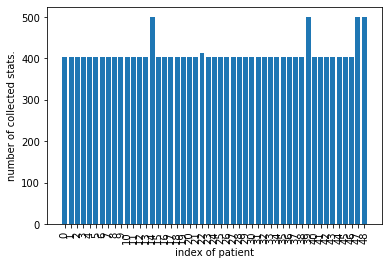

self.num_calls_to_getflagfinished = 193

 numstats in [404 , 500],     num zeros = 0


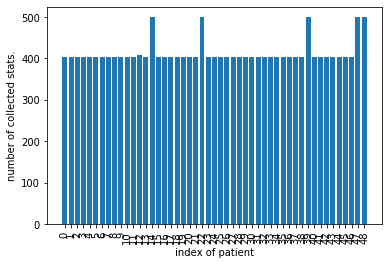

 got 1270 stats
self.num_calls_to_getflagfinished = 194

 numstats in [404 , 500],     num zeros = 0


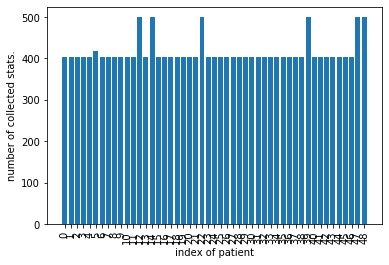

 got 1280 stats
self.num_calls_to_getflagfinished = 195

 numstats in [404 , 500],     num zeros = 0


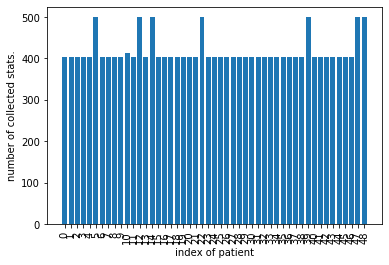

 got 1290 stats
self.num_calls_to_getflagfinished = 196

 numstats in [404 , 500],     num zeros = 0


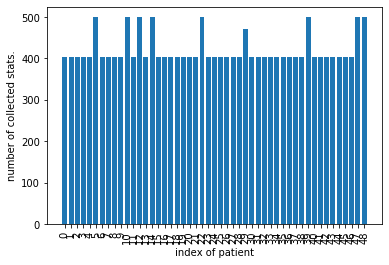

self.num_calls_to_getflagfinished = 197

 numstats in [404 , 500],     num zeros = 0


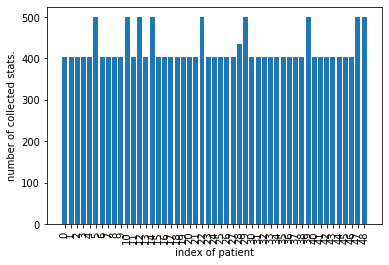

 got 1300 stats
self.num_calls_to_getflagfinished = 198

 numstats in [404 , 500],     num zeros = 0


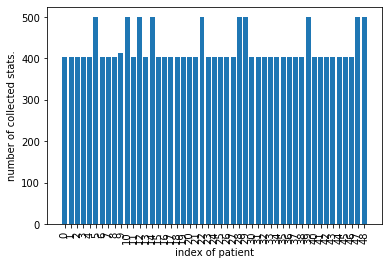

self.num_calls_to_getflagfinished = 199

 numstats in [404 , 500],     num zeros = 0


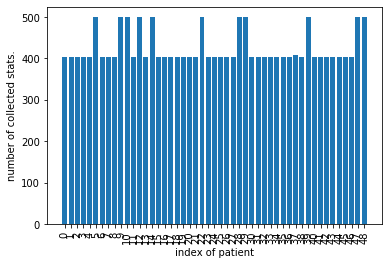

 got 1310 stats
self.num_calls_to_getflagfinished = 200

 numstats in [404 , 500],     num zeros = 0


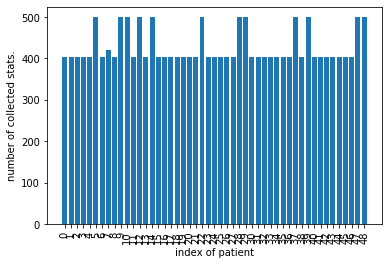

 got 1320 stats
self.num_calls_to_getflagfinished = 201

 numstats in [404 , 500],     num zeros = 0


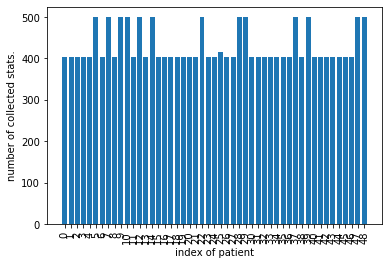

self.num_calls_to_getflagfinished = 202

 numstats in [404 , 500],     num zeros = 0


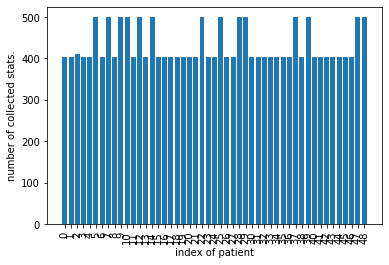

 got 1330 stats
self.num_calls_to_getflagfinished = 203

 numstats in [404 , 500],     num zeros = 0


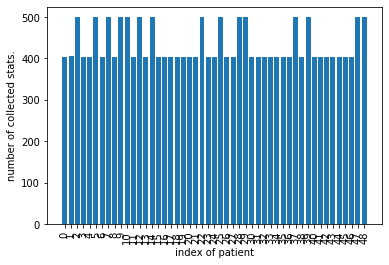

self.num_calls_to_getflagfinished = 204

 numstats in [404 , 500],     num zeros = 0


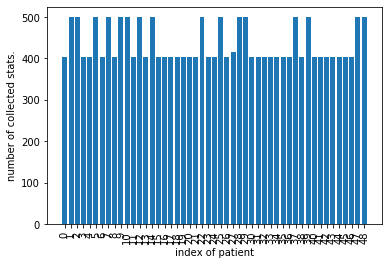

 got 1340 stats
self.num_calls_to_getflagfinished = 205

 numstats in [404 , 500],     num zeros = 0


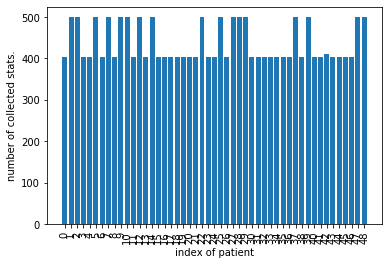

 got 1350 stats
self.num_calls_to_getflagfinished = 206

 numstats in [404 , 500],     num zeros = 0


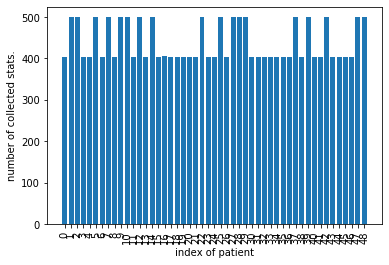

self.num_calls_to_getflagfinished = 207

 numstats in [404 , 500],     num zeros = 0


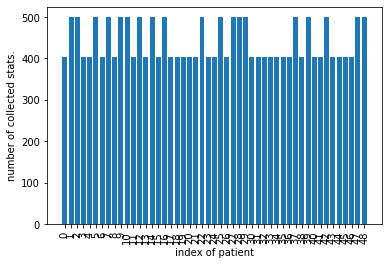

self.num_calls_to_getflagfinished = 208

 numstats in [404 , 500],     num zeros = 0


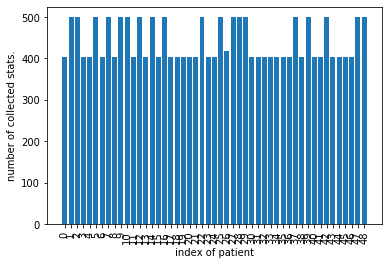

 got 1360 stats
self.num_calls_to_getflagfinished = 209

 numstats in [404 , 500],     num zeros = 0


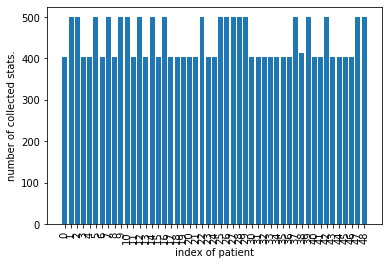

 got 1370 stats
self.num_calls_to_getflagfinished = 210

 numstats in [404 , 500],     num zeros = 0


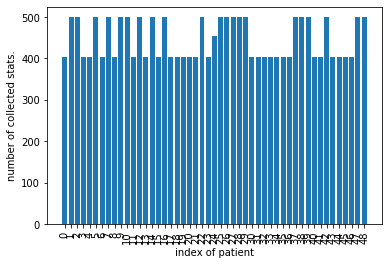

self.num_calls_to_getflagfinished = 211

 numstats in [404 , 500],     num zeros = 0


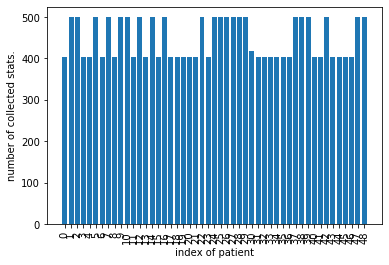

 got 1380 stats
self.num_calls_to_getflagfinished = 212

 numstats in [404 , 500],     num zeros = 0


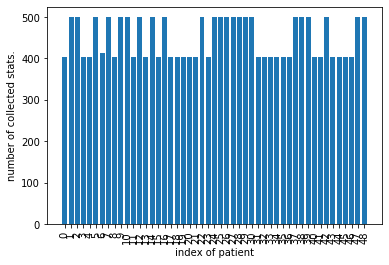

self.num_calls_to_getflagfinished = 213

 numstats in [404 , 500],     num zeros = 0


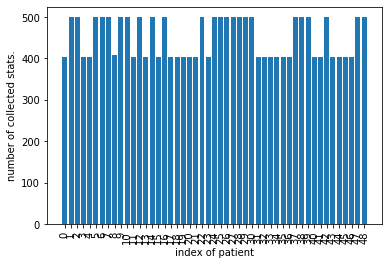

 got 1390 stats
 got 1400 stats
self.num_calls_to_getflagfinished = 214

 numstats in [404 , 500],     num zeros = 0


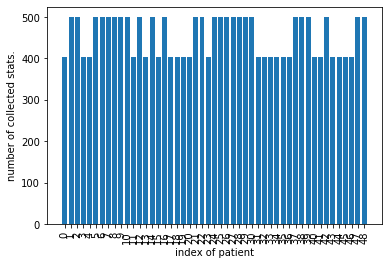

self.num_calls_to_getflagfinished = 215

 numstats in [404 , 500],     num zeros = 0


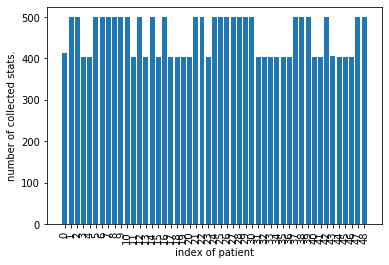

 got 1410 stats
self.num_calls_to_getflagfinished = 216

 numstats in [404 , 500],     num zeros = 0


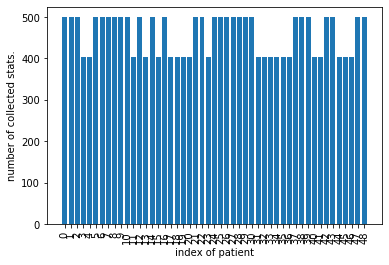

self.num_calls_to_getflagfinished = 217

 numstats in [404 , 500],     num zeros = 0


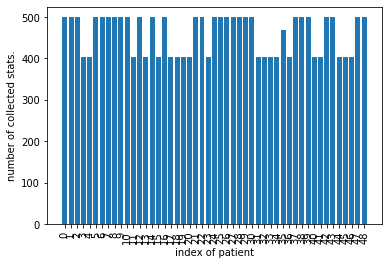

 got 1420 stats
self.num_calls_to_getflagfinished = 218

 numstats in [404 , 500],     num zeros = 0


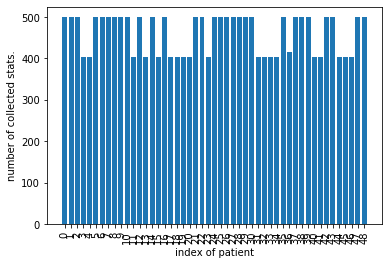

self.num_calls_to_getflagfinished = 219

 numstats in [404 , 500],     num zeros = 0


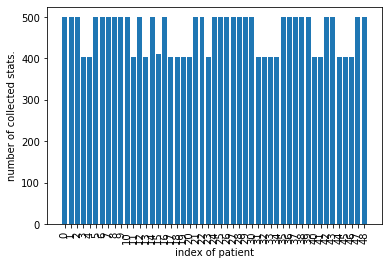

 got 1430 stats
self.num_calls_to_getflagfinished = 220

 numstats in [404 , 500],     num zeros = 0


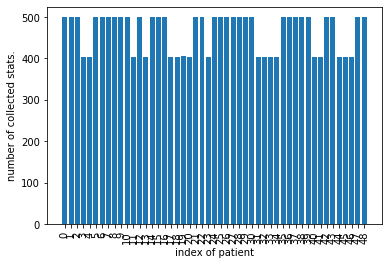

 got 1440 stats
self.num_calls_to_getflagfinished = 221

 numstats in [404 , 500],     num zeros = 0


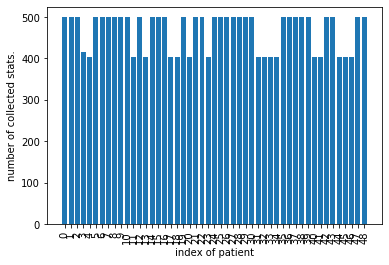

self.num_calls_to_getflagfinished = 222

 numstats in [404 , 500],     num zeros = 0


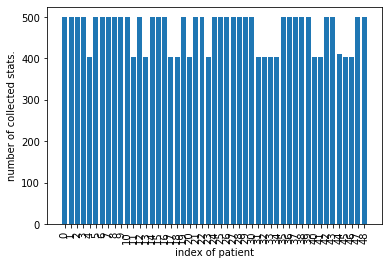

 got 1450 stats
self.num_calls_to_getflagfinished = 223

 numstats in [404 , 500],     num zeros = 0


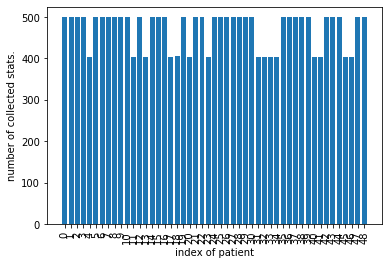

self.num_calls_to_getflagfinished = 224

 numstats in [404 , 500],     num zeros = 0


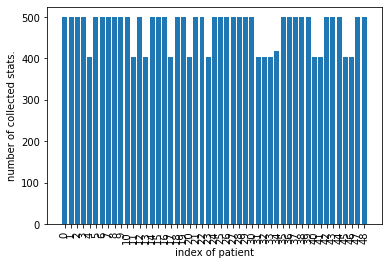

 got 1460 stats
self.num_calls_to_getflagfinished = 225

 numstats in [404 , 500],     num zeros = 0


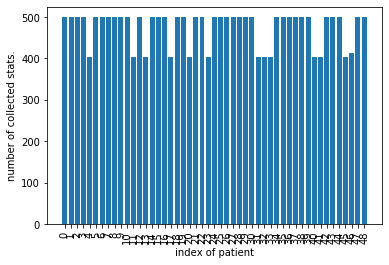

 got 1470 stats
self.num_calls_to_getflagfinished = 226

 numstats in [404 , 500],     num zeros = 0


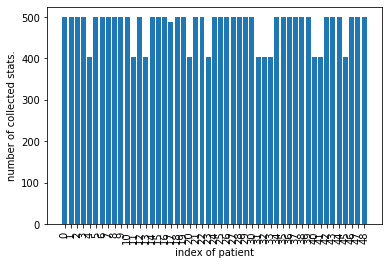

self.num_calls_to_getflagfinished = 227

 numstats in [404 , 500],     num zeros = 0


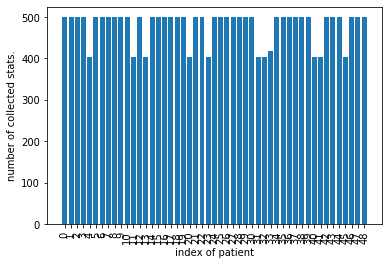

 got 1480 stats
self.num_calls_to_getflagfinished = 228

 numstats in [404 , 500],     num zeros = 0


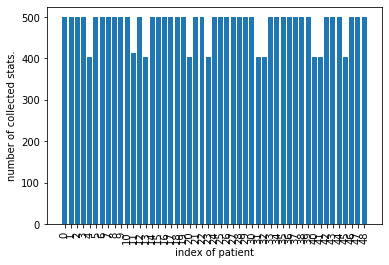

 got 1490 stats
self.num_calls_to_getflagfinished = 229

 numstats in [404 , 500],     num zeros = 0


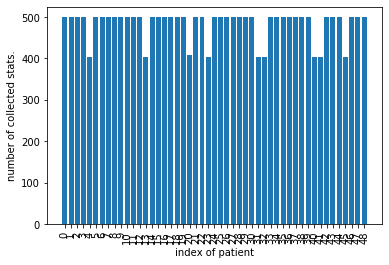

self.num_calls_to_getflagfinished = 230

 numstats in [404 , 500],     num zeros = 0


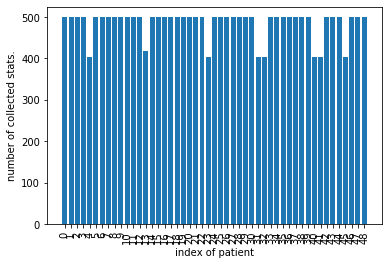

 got 1500 stats
self.num_calls_to_getflagfinished = 231

 numstats in [404 , 500],     num zeros = 0


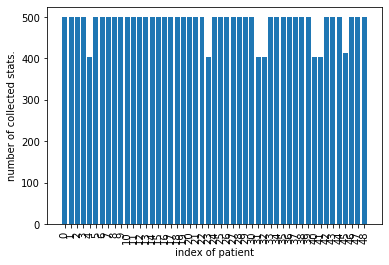

 got 1510 stats
self.num_calls_to_getflagfinished = 232

 numstats in [404 , 500],     num zeros = 0


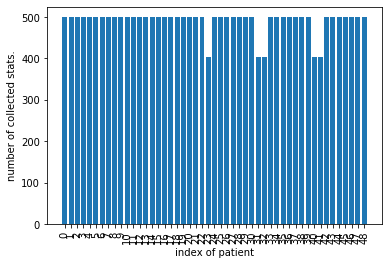

self.num_calls_to_getflagfinished = 233

 numstats in [404 , 500],     num zeros = 0


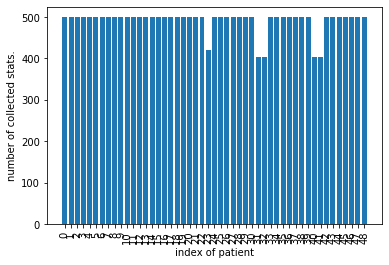

 got 1520 stats
self.num_calls_to_getflagfinished = 234

 numstats in [404 , 500],     num zeros = 0


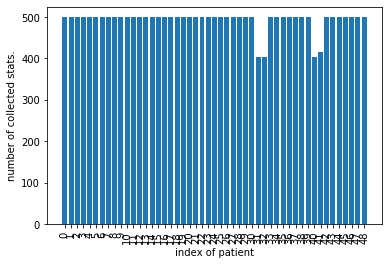

self.num_calls_to_getflagfinished = 235

 numstats in [404 , 500],     num zeros = 0


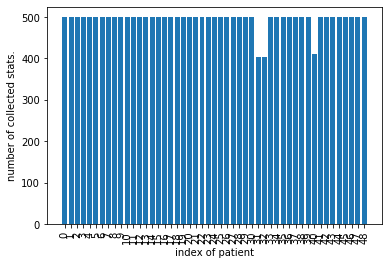

 got 1530 stats
self.num_calls_to_getflagfinished = 236

 numstats in [404 , 500],     num zeros = 0


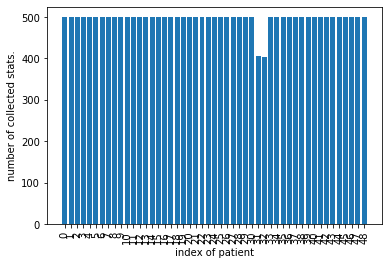

 got 1540 stats
self.num_calls_to_getflagfinished = 237

 numstats in [416 , 500],     num zeros = 0


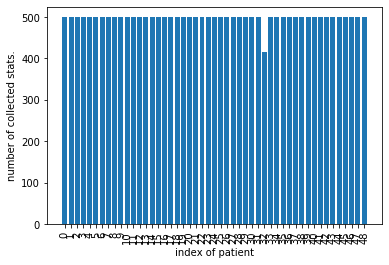

self.num_calls_to_getflagfinished = 238

 numstats in [500 , 500],     num zeros = 0


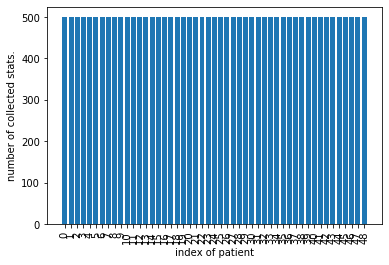

[-11.637985   -8.6147175]
1



[ -2.907781 -10.023519]
0



[ -1.3037525 -12.058068 ]
0



[ -8.261921 -14.632478]
0



[-4.1781955 -6.814436 ]
0



[ -5.699596 -11.076957]
0



[ -4.186045 -12.085716]
0



[-1.9884409 -7.7783732]
0



[ -2.7415292 -13.591688 ]
0



[ -1.2607296 -14.018498 ]
0



[-12.28323  -18.768944]
0



[-7.6465263 -7.5565157]
1



[-12.160143 -18.035301]
0



[-5.063571  -8.0070305]
0



[ -5.5881414 -11.691496 ]
0



[ -6.340941 -17.415577]
0



[-3.8259742 -9.636414 ]
0



[ -3.517613 -13.738045]
0



[ -0.56899923 -14.425919  ]
0



[-3.8415098 -7.897068 ]
0



[ -5.6782255 -10.008863 ]
0



[-2.6994462 -8.32747  ]
0



[ -7.615948 -18.606236]
0



[ -4.1624684 -11.821898 ]
0



[ -3.9177213 -16.835747 ]
0



[ -2.1946163 -12.583833 ]
0



[2.556386   0.33600286]
0



[ -5.1873455 -11.12083  ]
0



[-25.670576 -16.03521 ]
1



[-44.89631 -18.12169]
1



[-17.250862 -10.21789 ]
1



[-7.505042  -3.6609976]
1



[-13.171644 -14.615411]
0



[-4.4339943 -2.077081

In [9]:
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "mode_trainortest":"test",
    "width_bigchunk_at_5x":500,
    "heigh_bigchunk_at_5x":500,
    "width_smallchunk":224*2,
    "heigth_smallchunk":224*2,
    "num_bigchunkloaders":5,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":1000,
    "interval_resched": 10,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}
dl_of_statcollector = tcgaglioma.DLWithInTurnSched(
                              dataset=test_ds,\
                              type_bigchunkloader=tcgaglioma.WSIRandomBigchunkLoader,\
                              type_smallchunkcollector=tcgaglioma.WSIRandomSmallchunkCollector,\
                              const_global_info=const_global_info,\
                              batch_size=16, tfms=tfms,\
                              flag_grabqueue_onunsched = False
                           ) 
statcollector = tcgaglioma.TCGAGliomaStatCollector(
                                module_pipeline=model, device=device,\
                                lightdl=dl_of_statcollector,\
                                str_collectortype = "accum",\
                                flag_visualizestats=False
                             )
print("statcollector created.")
statcollector.start_collecting()
time.sleep(10) #to make sure that the data from subprocesses is transmitted
dict_patient_to_stats = statcollector.get_finalstats()
#compute dict_patient_to_avgencodeddescriptor ====================
dict_patient_to_avgencodeddescriptor = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
#         print(dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape)
        avgh_of_patient = dict_patient_to_stats[patient]["sum_encoded_descriptors"]
                #[200 x 14 x 14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200x14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200]
        avgh_of_patient = avgh_of_patient / dict_patient_to_stats[patient]["count"]
        avgh_of_patient = avgh_of_patient/\
                    (dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[1]*\
                     dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[2])
        dict_patient_to_avgencodeddescriptor[patient] = avgh_of_patient
    else:
        dict_patient_to_avgencodeddescriptor[patient] = None

#comput dict_patient_to_prob ========
dict_patient_to_prob = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
        avgh_of_patient = dict_patient_to_avgencodeddescriptor[patient] #[100]
        with torch.no_grad():
            tensor_hofpatient = torch.from_numpy(avgh_of_patient).float()\
                                .unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
            prob_of_patient = model.module_stg4(tensor_hofpatient).cpu().numpy()[:,:,0,0]
            dict_patient_to_prob[patient] = prob_of_patient
all_probs, all_tpscore, all_predy, all_color = [], [], [], []
for patient in dict_patient_to_prob.keys():
    all_probs.append(dict_patient_to_prob[patient].flatten())
    all_tpscore.append(float(tcgaglioma.func_getlabel_of_patient(patient)))
    all_predy.append(np.argmax(dict_patient_to_prob[patient].flatten()))
    print(all_probs[-1])
    print(all_predy[-1])
    print("\n\n")
all_probs = np.array(all_probs)

In [10]:
conf_matrix = tcgaglioma.confusion_matrix(all_predy, [int(u) for u in all_tpscore])
print("confusion matrix = \n {}".format(conf_matrix))
accuracy = (np.sum(np.diag(conf_matrix)))/np.sum(conf_matrix)
print("accuracy = {}".format(accuracy))

confusion matrix = 
 [[26.  2.]
 [ 4. 17.]]
accuracy = 0.8775510204081632


In [11]:
list_alltopscore = [int(u) for u in all_tpscore]
print(list_alltopscore)
print(all_predy)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
